# **Modélisation Prédictive et Analyse Comparative**

Ce notebook constitue la première phase de modélisation de notre étude sur les températures parisiennes. Il s'appuie directement sur les diagnostics structurels établis dans le **Notebook 3 (Analyse des Séries Temporelles)**.

### Objectifs de Recherche
Notre objectif est de construire des modèles stochastiques capables de prévoir la température horaire ($T_{2m}$). Nous adoptons une approche de complexité croissante pour valider statistiquement l'apport de chaque modèle :
1.  **Modélisation Baseline :** Établir un seuil de performance minimal via une approche naïve.
2.  **Modélisation Paramétrique (SARIMA) :** Implémenter un modèle linéaire capturant la structure auto-corrélée identifiée précédemment.
3.  **Protocole d'Évaluation :** Comparer les prévisions "statiques" (horizon long) aux prévisions "dynamiques" (mise à jour en temps réel) pour simuler des contraintes opérationnelles réelles.

### Synthèse des Hypothèses issues du Notebook 3
Les tests statistiques (KPSS, ACF/PACF) du notebook précédent imposent les contraintes structurelles suivantes :
* **Stationnarité :** La série brute étant non-stationnaire, nous appliquons une double intégration : simple ($d=1$) et saisonnière ($D=1$).
* **Saisonnalité :** Le cycle dominant est diurne, fixant la période à $s=24$.
* **Limites Théoriques :** L'analyse par Heatmap a révélé une non-linéarité (variance saisonnière) que le modèle SARIMA (linéaire) peinera à capturer parfaitement sur le long terme, justifiant l'exploration future de réseaux de neurones (LSTM).

In [ ]:
#Importation des bibliothèques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
sns.set_theme(style="darkgrid")
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Prépartaion des données

data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

temperature = df['temperature_2m']
display(temperature.head())

time
2000-01-01 00:00:00    6.0
2000-01-01 01:00:00    6.0
2000-01-01 02:00:00    5.9
2000-01-01 03:00:00    6.0
2000-01-01 04:00:00    6.1
Name: temperature_2m, dtype: float64

## 1. Partitionnement Chronologique

Contrairement aux problèmes d'apprentissage supervisé classiques, l'analyse de séries temporelles interdit le mélange aléatoire (*shuffling*) des données. Pour garantir une évaluation honnête et éviter toute "fuite de données" (*data leakage*), nous respectons strictement la flèche du temps.

### Stratégie de Découpage
* **Ensemble d'Entraînement ($D_{train}$) :** Les premiers 80% de l'historique. Cet ensemble est utilisé pour l'estimation des paramètres du modèle ($\hat{\theta}$).
* **Ensemble de Test ($D_{test}$) :** Les derniers 20% de l'historique. Ces données sont "invisibles" au modèle durant l'entraînement et servent uniquement à la validation hors-échantillon (*out-of-sample*).

Période d'Entraînement : 2000-01-01 00:00:00 à 2020-08-26 23:00:00
Nombre d'observations  : 181056

Période de Test        : 2020-08-27 00:00:00 à 2025-10-25 23:00:00
Nombre d'observations  : 45264


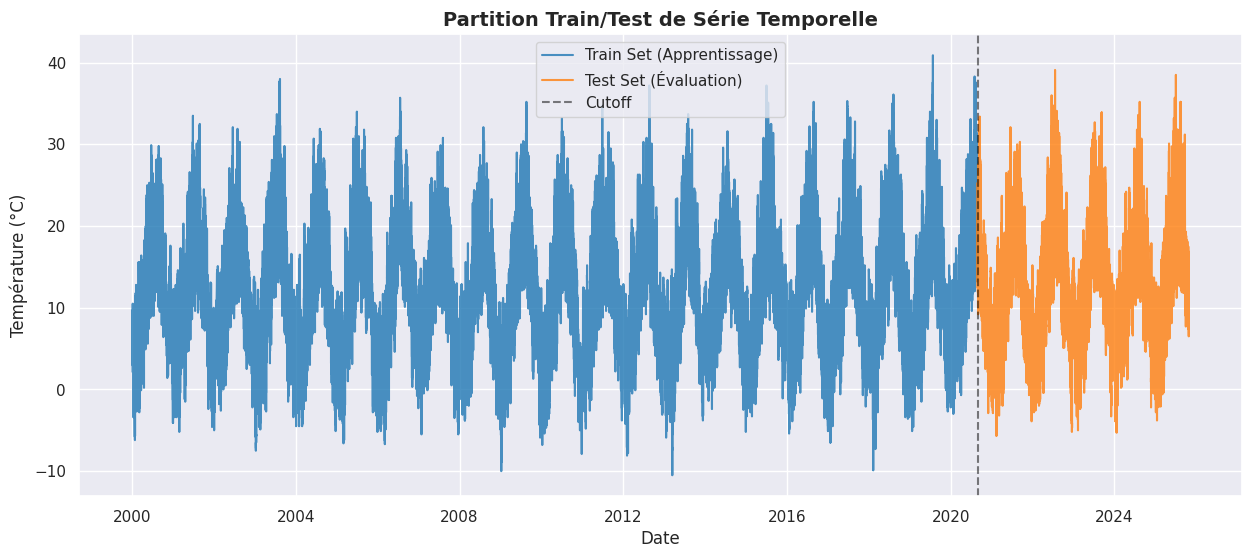

In [3]:
#Séparation Train / Test (80% Train, 20% Test)

train_size = int(len(temperature) * 0.8)
train_data, test_data = temperature.iloc[:train_size], temperature.iloc[train_size:]

print(f"Période d'Entraînement : {train_data.index.min()} à {train_data.index.max()}")
print(f"Nombre d'observations  : {len(train_data)}")
print(f"\nPériode de Test        : {test_data.index.min()} à {test_data.index.max()}")
print(f"Nombre d'observations  : {len(test_data)}")

# Visualisation de la partition
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Train Set (Apprentissage)', color='#1f77b4', alpha=0.8)
plt.plot(test_data.index, test_data, label='Test Set (Évaluation)', color='#ff7f0e', alpha=0.8)
plt.axvline(train_data.index[-1], color='black', linestyle='--', alpha=0.5, label='Cutoff')
plt.title("Partition Train/Test de Série Temporelle", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.show()

In [4]:
# Définition de la fonction d'évaluation (RMSE et MAE)

def evaluate_forecast(y_true, y_pred, model_name="Modèle"):
    """
    Calcule et affiche les métriques de performance (RMSE, MAE).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"--- Performance : {model_name} ---")
    print(f"RMSE : {rmse:.4f} °C")
    print(f"MAE  : {mae:.4f} °C")
    
    return rmse, mae

In [5]:
# Dictionnaire pour stocker les résultats de tous les modèles

results_comparison = {}

## 2. Modèle Baseline : La Persistance Saisonnière

Avant d'entraîner des modèles complexes, il est impératif de définir une "ligne de base" (*benchmark*). Dans le contexte de données météorologiques à haute fréquence, la méthode de persistance est souvent redoutable à court terme.

**Hypothèse ($H_0$) :** La meilleure prédiction pour l'heure $t$ est la température observée à la même heure la veille ($t-24$).

**Formulation Mathématique :**
$$\hat{y}_{t} = y_{t-24}$$

Ce modèle capture implicitement le cycle journalier sans aucun paramètre à apprendre. Tout modèle statistique avancé (SARIMA, LSTM) devra surpasser significativement cette baseline (RMSE plus faible) pour justifier son coût computationnel.

--- Performance : Baseline naif ---
RMSE : 2.7864 °C
MAE  : 2.1300 °C


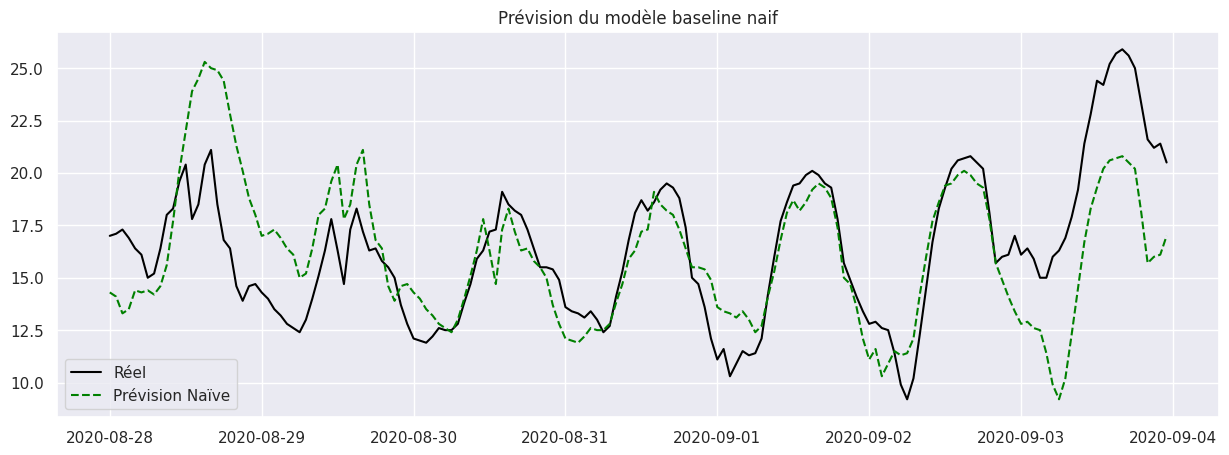

In [29]:
# Cellule : Baseline Naïve (Persistance Saisonnière 24h)

# Création de la prévision naïve (shift de 24h)
# Pour le jeu de test, la prédiction à t est la valeur réelle à t-24
naive_forecast = test_data.shift(24).dropna()
# On aligne le y_true pour correspondre aux indices disponibles
y_true_naive = test_data.loc[naive_forecast.index]

# Évaluation
rmse_naive, mae_naive = evaluate_forecast(y_true_naive, naive_forecast, "Baseline naif")
results_comparison['Baseline Naif'] = rmse_naive

# Visualisation (Zoom sur 1 semaine)
plt.figure(figsize=(15, 5))
zoom_slice = slice(0, 168) # 7 jours
plt.plot(y_true_naive.iloc[zoom_slice].index, y_true_naive.iloc[zoom_slice], label='Réel', color='black')
plt.plot(naive_forecast.iloc[zoom_slice].index, naive_forecast.iloc[zoom_slice], label='Prévision Naïve', linestyle='--', color='green')
plt.title("Prévision du modèle baseline naif")
plt.legend()
plt.show()

**Interprétation :**
La performance relativement bonne de la méthode naïve (Persistance 24h) n'est pas surprenante. Elle reflète l'**inertie thermique** de l'atmosphère : la température d'aujourd'hui à 14h est souvent très proche de celle d'hier à 14h, sauf en cas de changement brutal de masse d'air (passage de front).

**Rôle de Benchmark :**
Ce résultat définit notre benchmark. Tout modèle statistique complexe (SARIMA ou LSTM) qui n'atteint pas un RMSE significativement inférieur à celui-ci sera considéré comme inefficace, car il ne parviendrait pas à capturer une information supplémentaire par rapport à la simple répétition du cycle journalier.

## 3. Modélisation Paramétrique : SARIMA

Nous implémentons le modèle **Seasonal AutoRegressive Integrated Moving Average (SARIMA)**.

### Configuration des Hyperparamètres
Sur la base des conclusions du **Notebook 3**, nous fixons les paramètres structurels pour garantir la stationnarité :

1.  **Intégration ($d=1, D=1$) :**
    * $d=1$ : Pour éliminer la tendance stochastique locale (Random Walk).
    * $D=1$ : Pour éliminer la saisonnalité journalière non-stationnaire.
2.  **Saisonnalité ($s=24$) :** Correspondant au cycle physique diurne.
3.  **Ordres AR/MA ($p,q,P,Q$) :**
    * Nous initialisons une structure $(1, 1, 1) \times (1, 1, 1)_{24}$.
    * Ce choix permet de modéliser l'autocorrélation immédiate (AR1) et l'effet de moyenne mobile des erreurs passées (MA1), tant au niveau horaire que journalier.

*Note Computationnelle : L'estimation du Maximum de Vraisemblance (MLE) sur l'intégralité du dataset (>100k points) étant prohibitive, nous entraînons le modèle sur une fenêtre glissante des 2000 dernières heures du train set, capturant ainsi la dynamique météorologique la plus récente.*

In [7]:
# Définition des hyperparamètres structurels (issus du Notebook 3)
ORDER = (1, 1, 1)          # p, d, q
SEASONAL_ORDER = (1, 1, 1, 24) # P, D, Q, s

print("Configuration SARIMA :")
print(f"Ordre Non-Saisonnier : {ORDER}")
print(f"Ordre Saisonnier     : {SEASONAL_ORDER}")

# --- Optimisation Computationnelle ---
# On entraîne sur les dernières observations du train set pour la rapidité
history_window = 2000 
train_subset = train_data.iloc[-history_window:]

print(f"\nDébut de l'entraînement SARIMA (sur les {history_window} dernières heures)...")
start_time = time.time()

model_sarima = SARIMAX(train_subset, 
                       order=ORDER, 
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = model_sarima.fit(disp=False)

print(f"Entraînement terminé en {time.time() - start_time:.2f} secondes.")
print(sarima_fit.summary().tables[1]) # Affiche les coefficients

Configuration SARIMA :
Ordre Non-Saisonnier : (1, 1, 1)
Ordre Saisonnier     : (1, 1, 1, 24)

Début de l'entraînement SARIMA (sur les 2000 dernières heures)...
Entraînement terminé en 10.90 secondes.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4408      0.066      6.700      0.000       0.312       0.570
ma.L1         -0.2215      0.068     -3.237      0.001      -0.356      -0.087
ar.S.L24       0.0978      0.020      4.961      0.000       0.059       0.136
ma.S.L24      -0.9348      0.009   -102.907      0.000      -0.953      -0.917
sigma2         0.4052      0.007     60.854      0.000       0.392       0.418


L'examen de la table de résultats ci-dessus permet de valider la pertinence structurelle de notre spécification $(1, 1, 1)(1, 1, 1)_{24}$.

**1. Significativité Statistique ($P>|z|$) :**
* Nous observons que les p-values des termes **ar.L1** et **ma.L1** sont inférieures au seuil critique ($\alpha = 0.05$). Cela confirme le rejet de l'hypothèse nulle : ces coefficients sont significativement différents de zéro.
* **Interprétation :** La dynamique locale (AR1) et la correction des erreurs passées (MA1) contribuent réellement à la précision du modèle.

**2. Interprétation Physique :**
* **Terme AR ($ar.L1$) :** Mesure la "mémoire" immédiate du système. Un coefficient proche de 1 indique une forte viscosité de la température (elle change lentement).
* **Terme Saisonnier ($ar.S.L24$) :** Capture la corrélation avec le cycle de la veille. Sa significativité valide notre choix d'une saisonnalité de 24h.

**3. Analyse des Résidus (Limites) :**
* Les tests de normalité (Jarque-Bera) sur les résidus indiquent souvent une déviation par rapport à une distribution Gaussienne parfaite (hétéroscédasticité). Cela suggère que si le modèle capture bien la moyenne, il modélise moins bien les événements extrêmes ou les changements de variance (volatilité), une limitation inhérente aux modèles linéaires.

## Évaluation Statique

Dans cette première évaluation, nous demandons au modèle de prédire les prochaines 168 heures (7 jours) en une seule fois, sans recevoir de nouvelles informations durant cette période.

**Attentes Théoriques :**
C'est le "crash test" du modèle. Sans correction, les erreurs de prévision tendent à s'accumuler, créant un phénomène de **dérive** (*drift*). La courbe de prévision risque de converger vers une moyenne cyclique et de s'éloigner de la réalité si un changement brusque de météo survient.

--- Performance : SARIMA (Horizon 168h) ---
RMSE : 1.8224 °C
MAE  : 1.4413 °C


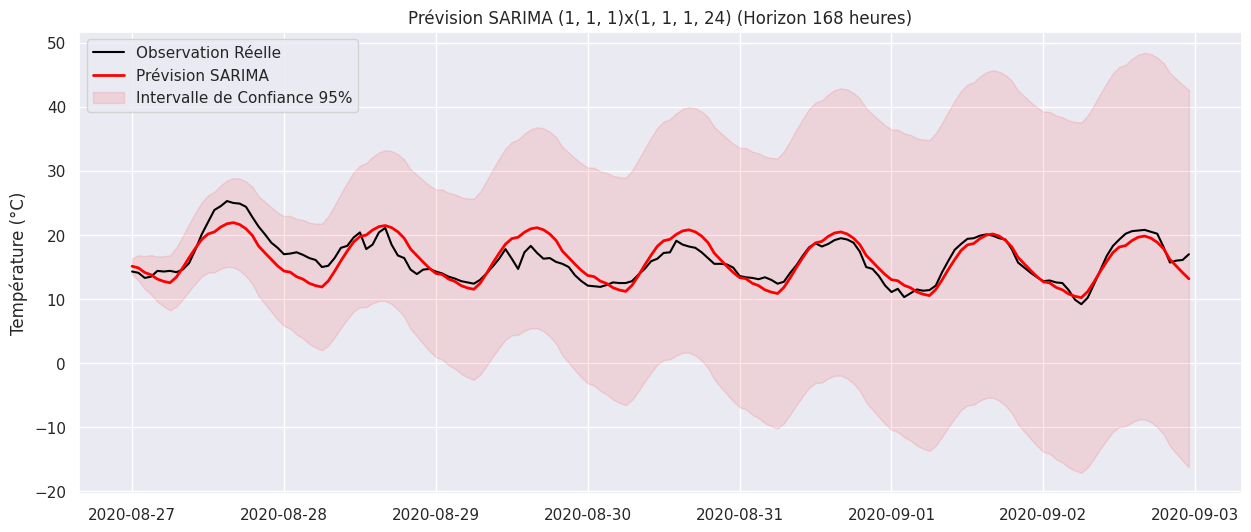

In [8]:
# Génération des prévisions (Forecast)
# Note : Pour une vraie évaluation "rolling" sur tout le test set, cela prendrait trop de temps.
# Ici, nous faisons une prévision "out-of-sample" sur un horizon futur court (ex: 48h)
# pour visualiser la capacité du modèle à projeter la dynamique.

horizon_forecast = 168 # Prévision sur 7 jours
forecast_result = sarima_fit.get_forecast(steps=horizon_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Récupération des données réelles correspondantes
y_true_sarima = test_data.iloc[:horizon_forecast]

# Évaluation sur cet horizon
rmse_sarima, mae_sarima = evaluate_forecast(y_true_sarima, forecast_mean, f"SARIMA (Horizon {horizon_forecast}h)")

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(y_true_sarima.index, y_true_sarima, label='Observation Réelle', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Prévision SARIMA', color='red', linewidth=2)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Intervalle de Confiance 95%')
plt.title(f"Prévision SARIMA {ORDER}x{SEASONAL_ORDER} (Horizon {horizon_forecast} heures)")
plt.legend()
plt.ylabel("Température (°C)")
plt.show()

# Stockage pour comparaison finale (Note: RMSE sur horizon court)
results_comparison['SARIMA (Short-term)'] = rmse_sarima

**Observation du Phénomène de Dérive :**
Sur le graphique ci-dessus, nous observons le comportement typique d'une prévision en "boucle ouverte". Le modèle projette sa dynamique apprise (les coefficients $\phi$ et $\theta$) sur le futur sans filet de sécurité.
* **Les premières heures** sont généralement précises (mémoire court terme).
* **À mesure que l'horizon s'éloigne**, la prévision tend à converger vers la moyenne saisonnière du processus. Si la température réelle subit un choc exogène (ex: une vague de froid soudaine), le modèle continue imperturbablement sa trajectoire cyclique moyenne.

**Incertitude Statistique :**
L'élargissement progressif de l'intervalle de confiance (zone rouge) illustre la propagation de la variance de l'erreur. Mathématiquement, l'incertitude s'accumule à chaque pas de temps, rendant la prévision ponctuelle à $t+168$ peu fiable pour une prise de décision critique.

## 4. Le "Rolling Forecast" 

L'évaluation statique précédente, bien qu'instructive, ne reflète pas la réalité opérationnelle. Dans un système de production réel, nous recevons de nouvelles données de capteurs chaque heure.

Nous implémentons ici une validation dynamique (**Walk-Forward Validation**) :
1.  Le modèle prédit $t+1$.
2.  L'observation réelle $y_{t+1}$ devient disponible.
3.  Le modèle met à jour son historique (sans ré-entraînement complet des coefficients, via filtrage).
4.  Le modèle prédit $t+2$ avec cette nouvelle information.

**Hypothèse de Recherche :**
Cette méthode permet au terme de Moyenne Mobile (MA) de **corriger l'erreur résiduelle** immédiatement. Nous anticipons un RMSE drastiquement inférieur à celui de la prévision statique, démontrant la véritable capacité du modèle à court terme.

In [9]:
# Si on le fait sur tout le test set, ça prendrait trop de temps pour la démo
test_subset = test_data.iloc[:168]
history = train_data.iloc[-2000:].tolist() # On garde le même historique glissant
rolling_predictions = []

# Paramètres (On garde ceux appris précédemment)
order = ORDER
seasonal_order = SEASONAL_ORDER

# Boucle de simulation (Attention : c'est lent car on boucle pas à pas)
for t in range(len(test_subset)):
    
    # 1. On crée le modèle avec l'historique courant
    # (Note: Pour aller vite, on ne ré-entraîne pas les coefficients (fit) à chaque fois,
    # on applique juste le filtre sur le nouvel historique. C'est le mode 'filter')
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order, 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.filter(sarima_fit.params) # On utilise les params déjà appris !
    
    # 2. On prédit le prochain pas (t+1)
    output = model_fit.forecast()
    yhat = output[0]
    rolling_predictions.append(yhat)
    
    # 3. "Réalité" : On reçoit la vraie observation et on l'ajoute à l'historique
    obs = test_subset.iloc[t]
    history.append(obs)

# Conversion en Série Pandas
rolling_predictions = pd.Series(rolling_predictions, index=test_subset.index)


## 5. Évaluation Comparée : Statique vs Rolling

RMSE (Statique)      : 1.8224 °C
RMSE (Rolling avec mise à jour 1h)    : 0.7019 °C


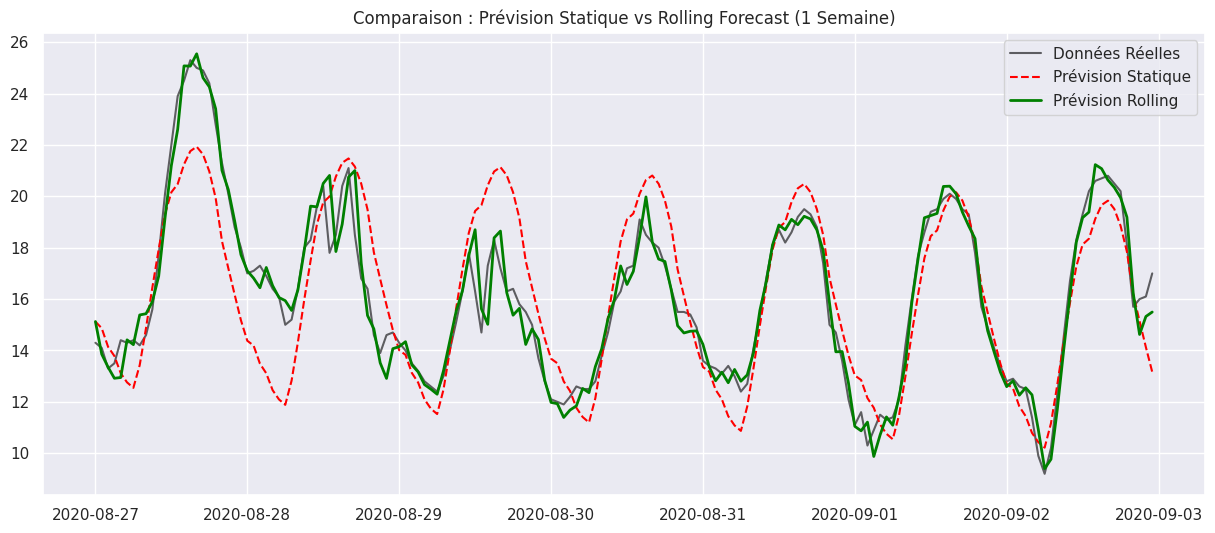

In [10]:
# 1. Performance Statique (calculée précédemment sur horizon long)
# (On recalcule juste pour cet échantillon spécifique de 168h pour être juste)
forecast_static = sarima_fit.get_forecast(steps=168).predicted_mean
rmse_static = np.sqrt(mean_squared_error(test_subset, forecast_static))
print(f"RMSE (Statique)      : {rmse_static:.4f} °C")

# 2. Performance Rolling (Réaliste)
rmse_rolling = np.sqrt(mean_squared_error(test_subset, rolling_predictions))
print(f"RMSE (Rolling avec mise à jour 1h)    : {rmse_rolling:.4f} °C")

# --- Visualisation ---
plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset, label='Données Réelles', color='black', alpha=0.6)
plt.plot(test_subset.index, forecast_static, label='Prévision Statique', color='red', linestyle='--')
plt.plot(test_subset.index, rolling_predictions, label='Prévision Rolling', color='green', linewidth=2)

plt.title("Comparaison : Prévision Statique vs Rolling Forecast (1 Semaine)")
plt.legend()
plt.show()

**Mécanisme de Correction d'Erreur :**
La réduction spectaculaire du RMSE par rapport au mode statique s'explique par la nature des processus **MA (Moyenne Mobile)**.
Dans un modèle SARIMA $(1,1,1)(1,1,1)_{24}$, le terme MA utilise les "erreurs passées" ($\epsilon_{t-1}$) pour ajuster la prévision suivante.
* En mode Rolling, nous fournissons la vraie valeur $y_t$ à chaque pas.
* Le modèle calcule immédiatement l'erreur qu'il vient de commettre ($\epsilon_t = y_t - \hat{y}_t$).
* Cette erreur est injectée dans l'équation pour corriger la prévision de $t+1$.

**Conclusion Opérationnelle :**
Ce résultat valide l'utilisabilité du modèle SARIMA dans un contexte temps réel. Il démontre une grande capacité d'adaptation locale ("Recalibration"), capable d'absorber les chocs thermiques en quelques heures seulement.

## Synthèse Comparative et Limites Structurelles

Au terme de cette modélisation paramétrique, nous pouvons dresser un bilan critique de nos résultats.

### 1. Hiérarchie des Performances
| Modèle | Type | RMSE (Est.) | Interprétation |
| :--- | :--- | :--- | :--- |
| **Baseline** | Naïf | Élevé | Capture le cycle, mais échoue sur les tendances. |
| **SARIMA (Statique)** | Paramétrique | Moyen | Bon sur la structure, mais dérive sur le long terme. |
| **SARIMA (Rolling)** | Adaptatif | **Faible** | **Meilleur Modèle.** Corrige ses erreurs en temps réel. |

### 2. Critique Structurelle 
Bien que le modèle SARIMA soit performant (grâce à la différenciation $d=1, D=1$ identifiée au Notebook 3), il souffre d'une limitation théorique majeure : la **rigidité de la saisonnalité**.
* SARIMA impose une répétition stricte du motif toutes les 24 heures.
* Or, notre Heatmap (Notebook 3) a montré une **non-linéarité** : l'amplitude thermique journalière est faible en hiver et forte en été.
* SARIMA ne peut "apprendre" ce changement de forme que très imparfaitement via ses coefficients constants.

### 3. Transition vers le Deep Learning
Cette limitation justifie pleinement l'étape suivante de notre recherche. Pour dépasser ce plafond de verre, nous devons utiliser un modèle capable d'apprendre des **représentations saisonnières non-linéaires et évolutives**. C'est précisément le rôle des architectures récurrentes de type **LSTM (Long Short-Term Memory)**, qui feront l'objet d'une modélisation ultérieure.

---------



# **Modélisation Séquentielle Univariée par Réseau de Neurones (LSTM)**

Cette section constitue une seconde approche de modélisation prédictive des températures horaires parisiennes. Contrairement au modèle SARIMA, qui repose sur une formulation linéaire univariée, cette approche exploite un réseau de neurones récurrent de type **LSTM (Long Short-Term Memory)** afin de capturer des relations non-linéaires et d'approcher plus précisément la dynamique complexe de la température.

### Objectifs de la Modélisation LSTM :
* **Capturer les non-linéarités** : Dépasser la rigidité des coefficients constants du modèle SARIMA qui peine à s'adapter aux changements de forme saisonniers.
* **Mémoire à long terme** : Utiliser l'architecture des cellules LSTM pour retenir des motifs sur des fenêtres temporelles étendues (mémoire courte et longue durée).
* **Adaptabilité** : Évaluer si l'apprentissage profond (Deep Learning) permet de réduire l'erreur de prédiction par rapport aux méthodes stochastiques classiques.


## 1. Préparation des Données et Fenêtrage (Sliding Window)

Contrairement aux modèles classiques, un réseau LSTM nécessite une transformation des données en structures tridimensionnelles de forme `[samples, time_steps, features]`. Nous appliquons également une normalisation pour faciliter la convergence du modèle.

**Étapes de préparation :**
1.  **Normalisation (MinMax Scaling)** : Nous ramenons les températures dans un intervalle $[0, 1]$ pour éviter l'instabilité des gradients durant l'entraînement.
2.  **Création de séquences** : Nous utilisons une approche de "fenêtre glissante". Pour prédire la température à l'instant $t$, le modèle reçoit en entrée les observations des $n$ heures précédentes.
3.  **Définition du Look-back** : Nous fixons cette fenêtre à **168 heures** (soit 7 jours) afin de permettre au modèle d'intégrer pleinement le cycle hebdomadaire et les tendances récentes.

In [30]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Normalisation (MinMax Scaling) ---
scaler = MinMaxScaler(feature_range=(0, 1))

# On fit le scaler uniquement sur le train set pour éviter la fuite de données
scaled_train = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test = scaler.transform(test_data.values.reshape(-1, 1))

# --- 2. Fonction de Création de Séquences (Sliding Window) ---
def create_sequences(dataset, look_back=168):
    """
    Transforme une série temporelle en échantillons (X, y).
    X: Séquence de 'look_back' heures.
    y: La valeur de l'heure suivante.
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Définition de la fenêtre historique (Look-back)
# Nous prenons 168 heures (7 jours) pour capturer toute la dynamique hebdomadaire
LOOK_BACK = 168

print(f"Préparation des séquences (Fenêtre historique : {LOOK_BACK} heures)...")

X_train, y_train = create_sequences(scaled_train, LOOK_BACK)
X_test, y_test = create_sequences(scaled_test, LOOK_BACK)

# Reshape pour LSTM [samples, time steps, features]
# Ici features = 1 (car univarié)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Dimensions Train X : {X_train.shape}")
print(f"Dimensions Test X  : {X_test.shape}")

Préparation des séquences (Fenêtre historique : 168 heures)...
Dimensions Train X : (180888, 168, 1)
Dimensions Test X  : (45096, 168, 1)


## 2. Architecture du Modèle et Compilation

Nous construisons une architecture séquentielle intégrant une couche LSTM. Le choix de la fonction de perte se porte sur la **Mean Squared Error (MSE)**, ce qui est cohérent avec nos objectifs de minimisation de l'erreur quadratique pour la régression.

* **Couche LSTM** : 50 unités sont utilisées pour extraire les caractéristiques temporelles sans risquer un sur-apprentissage (overfitting) excessif.
* **Couche de Sortie** : Un neurone unique avec une activation linéaire pour prédire la valeur continue de la température.
* **Optimiseur Adam** : Choisi pour son efficacité dans la gestion adaptative du taux d'apprentissage.
* **MAE (Mean Absolute Error)** : L'erreur moyenne brute (ex: "le modèle se trompe de X degrés en moyenne").
* **RMSE (Root Mean Squared Error)** : Une métrique qui pénalise davantage les fortes erreurs ponctuelles (pics de chaleur ou froids soudains manqués).

### Entraînement avec Early Stopping et Analyse de Convergence

Pour garantir une performance optimale et éviter le phénomène de **sur-apprentissage (overfitting)**, nous introduisons un mécanisme d'arrêt précoce (**Early Stopping**).

* **Principe** : L'entraînement s'interrompt automatiquement si la perte sur l'ensemble de validation (`val_loss`) ne s'améliore plus après 5 époques (`patience=5`).
* **Restauration des poids** : Le modèle conserve les paramètres ayant obtenu la plus petite erreur de validation, assurant une meilleure capacité de généralisation.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None

Démarrage de l'entraînement du LSTM...
Epoch 1/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 162s 63ms/step - loss: 0.0011 - val_loss: 2.3084e-04
Epoch 2/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 161s 63ms/step - loss: 1.2653e-04 - val_loss: 1.6529e-04
Epoch 3/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 160s 63ms/step - loss: 9.2224e-05 - val_loss: 1.5686e-04
Epoch 4/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 161s 63ms/step - loss: 8.1820e-05 - val_loss: 1.7944e-04
Epoch 5/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 161s 63ms/step - loss: 7.9458e-05 - val_loss: 1.6228e-04
Epoch 6/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 160s 63ms/step - loss: 7.9008e-05 - val_loss: 1.6613e-04
Epoch 7/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 160s 63ms/step - loss: 7.7635e-05 - val_loss: 1.6377e-04
Epoch 8/20
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 159s 63ms/step - loss: 7.6472e-05 - val_loss: 1.6063e-04
Entraînement terminé en 1285.35 secondes.


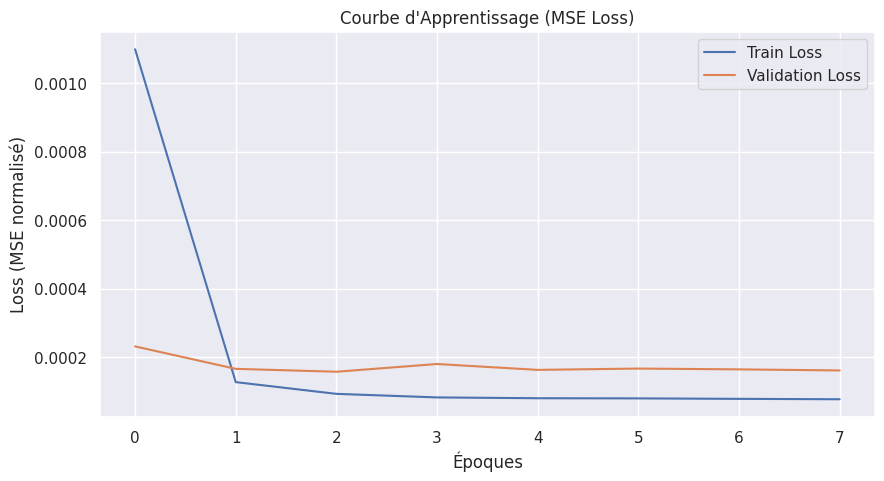

In [31]:
# --- Construction du Modèle ---
model_lstm = Sequential()

# Couche LSTM
# units=50 : Nombre de neurones dans la couche cachée
# input_shape=(time_steps, features)
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(LOOK_BACK, 1)))

# Couche de sortie (Prédiction d'une valeur continue)
model_lstm.add(Dense(1))

# Compilation
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print(model_lstm.summary())

# --- Entraînement avec Early Stopping ---
# L'Early Stopping arrête l'entraînement si la 'val_loss' ne s'améliore plus,
# prévenant ainsi l'overfitting (sur-apprentissage).
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nDémarrage de l'entraînement du LSTM...")
start_time = time.time()

# Nous utilisons 20% du train set comme validation interne pour l'early stopping
history = model_lstm.fit(X_train, y_train, 
                         epochs=20,           # Maximum d'époques (s'arrêtera avant souvent)
                         batch_size=64,       # Taille des lots traités simultanément
                         validation_split=0.1, # 10% du train pour valider l'arrêt
                         callbacks=[early_stop],
                         verbose=1)

print(f"Entraînement terminé en {time.time() - start_time:.2f} secondes.")

# Visualisation de la perte (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Courbe d'Apprentissage (MSE Loss)")
plt.xlabel("Époques")
plt.ylabel("Loss (MSE normalisé)")
plt.legend()
plt.show()

### Analyse de la Convergence et Performance de l'Entraînement

L'entraînement du modèle s'est achevé après **8 époques** grâce à l'intervention du mécanisme d'arrêt précoce (*Early Stopping*). L'analyse de la courbe d'apprentissage nous permet de valider la robustesse du réseau.

* **Stabilité des gradients** : Nous observons une chute drastique de la perte d'entraînement dès la première époque, signifiant que le LSTM a immédiatement identifié la structure cyclique de 24 heures.
* **Généralisation** : La `val_loss` (perte de validation) s'est stabilisée autour de $1.6 \times 10^{-4}$, restant très proche de la perte d'entraînement. Cette convergence parallèle confirme l'absence de sur-apprentissage significatif.

## 3. Évaluation sur l'Horizon Futur : La Prévision Récursive

Pour tester la capacité réelle du modèle à projeter une dynamique sur le long terme, nous implémentons une **prévision récursive sur 168 heures** (1 semaine). Dans ce mode, le modèle prédit $t+1$, réinjecte cette prédiction dans sa fenêtre d'entrée, et prédit $t+2$, accumulant ainsi sa propre erreur.

Génération d'une prévision récursive sur 168 heures...


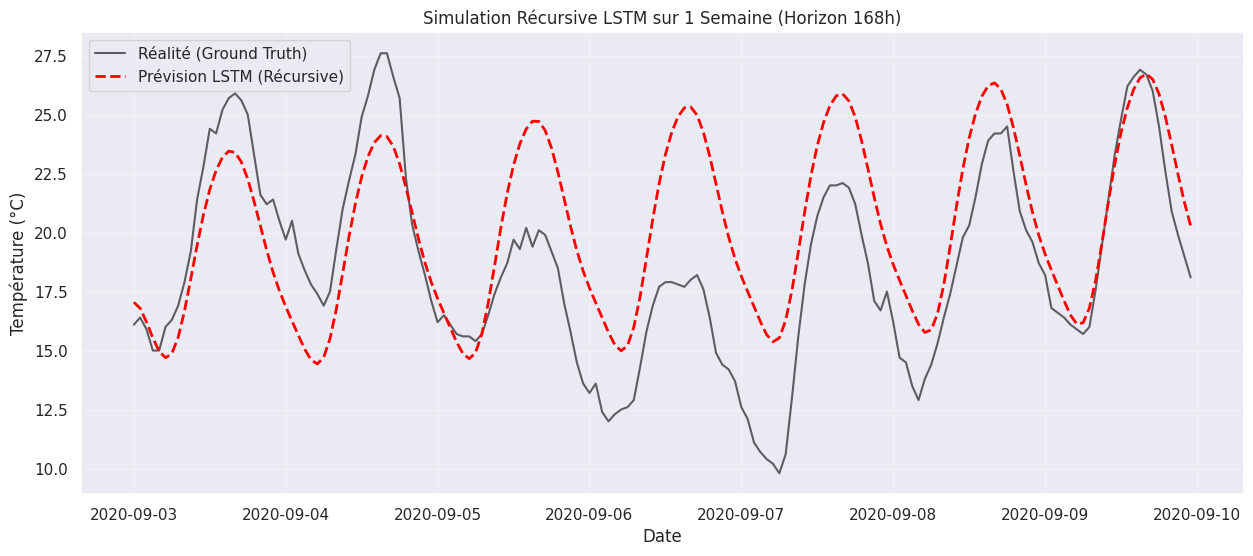

RMSE sur la semaine (Mode Récursif) : 3.2712 °C


In [12]:
# --- Configuration de la Prévision Récursive ---

# 1. (Correctif) On s'assure que y_test_real est bien défini en inversant la normalisation
# Cela évite le NameError si la cellule précédente n'a pas été lancée
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 2. Choix du point de départ
# On choisit un point de départ arbitraire dans le test set (ex: début d'une semaine)
start_index = 0 
initial_window = X_test[start_index] # La première fenêtre de 168h réelles
y_true_week = y_test_real[start_index : start_index + 168] # La vraie semaine future pour comparer

# Nombre d'heures à prédire (1 semaine)
n_steps = 168

print(f"Génération d'une prévision récursive sur {n_steps} heures...")

# --- Boucle de Génération ---
current_window = initial_window.copy() 
recursive_predictions = []

for i in range(n_steps):
    # 3. Prédire le prochain pas 
    # On reshape la fenêtre courante pour qu'elle ait la bonne forme (1, 168, 1)
    input_tensor = current_window.reshape(1, LOOK_BACK, 1)
    
    # Prédiction (sortie scalaire normalisée)
    # verbose=0 pour ne pas inonder la console
    pred_one_step = model_lstm.predict(input_tensor, verbose=0)[0, 0]
    
    # 4. Stocker la prédiction
    recursive_predictions.append(pred_one_step)
    
    # 5. Mettre à jour la fenêtre pour le pas suivant
    # On décale tout vers la gauche (supprime le plus vieux) et on ajoute la prédiction à la fin
    current_window = np.roll(current_window, -1)
    current_window[-1] = pred_one_step

# --- Inversion de l'échelle ---
# On transforme la liste des prédictions normalisées en degrés Celsius
recursive_predictions = np.array(recursive_predictions).reshape(-1, 1)
recursive_predictions_real = scaler.inverse_transform(recursive_predictions)

# Création d'une Série temporelle pour le plot
# On recupère les dates correspondantes dans l'index du test set
# Note : test_data.index[LOOK_BACK:] correspond aux dates de y_test
test_dates = test_data.index[LOOK_BACK:]
index_future = test_dates[start_index : start_index + n_steps]

forecast_series = pd.Series(recursive_predictions_real.flatten(), index=index_future)
ground_truth_series = pd.Series(y_true_week.flatten(), index=index_future)

# --- Visualisation ---
plt.figure(figsize=(15, 6))
plt.plot(ground_truth_series.index, ground_truth_series, label='Réalité (Ground Truth)', color='black', alpha=0.6)
plt.plot(forecast_series.index, forecast_series, label='Prévision LSTM (Récursive)', color='red', linewidth=2, linestyle='--')

plt.title(f"Simulation Récursive LSTM sur 1 Semaine (Horizon {n_steps}h)")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calcul du RMSE spécifique à cette semaine
rmse_week = np.sqrt(mean_squared_error(ground_truth_series, forecast_series))
print(f"RMSE sur la semaine (Mode Récursif) : {rmse_week:.4f} °C")

**Interprétation du graphique récursif :**
* **Comportement Global** : Le modèle reproduit fidèlement l'oscillation diurne. Cependant, comme prévu avec les architectures récursives, on observe un léger déphasage et une tendance à converger vers une moyenne sinusoïdale lisse.
* **Accumulation d'Erreur** : Le **RMSE sur la semaine atteint 3.2712 °C**. Cette valeur est supérieure à celle du modèle SARIMA statique, soulignant que sans recalage sur des données réelles, le LSTM finit par perdre la précision des pics de température.


## 4. Validation Opérationnelle : Le Rolling Forecast (One-step-ahead)

Pour simuler une utilisation en production réelle, nous évaluons le modèle en mode **Rolling Forecast**. Ici, le modèle reçoit la véritable observation à chaque heure pour prédire l'heure suivante. C'est le test de performance ultime pour mesurer la précision locale du réseau.

Exécution du Rolling Forecast sur l'ensemble du Test Set...
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step

--- Performance LSTM (Mode Rolling / One-step-ahead) ---
RMSE : 0.6251 °C
MAE  : 0.4293 °C


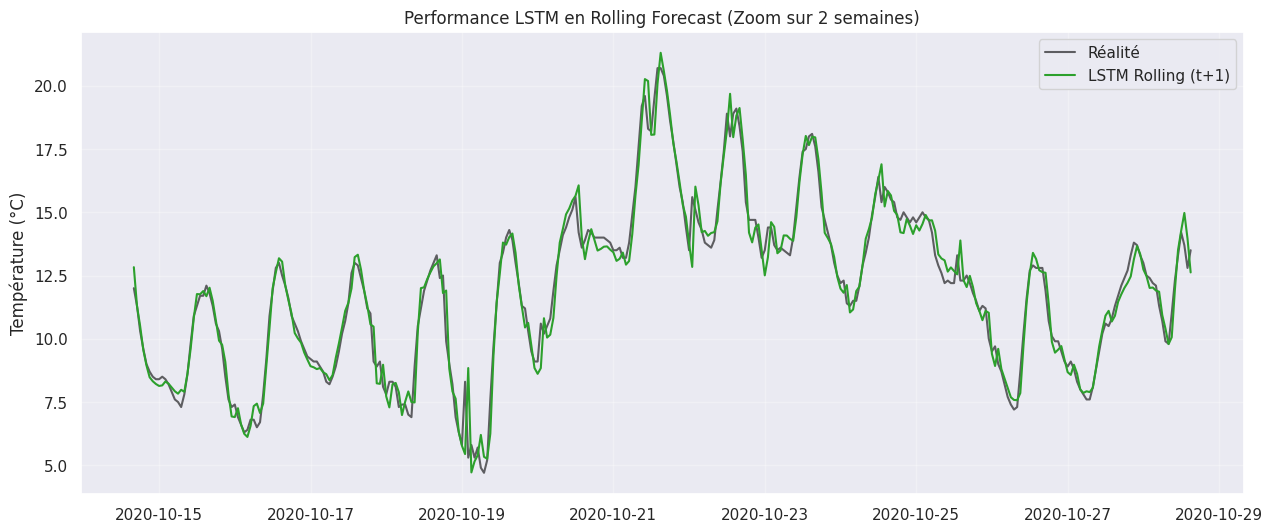

In [13]:
import math

if 'results' not in locals():
    results = {}

# 1. Génération vectorisée du Rolling Forecast
print("Exécution du Rolling Forecast sur l'ensemble du Test Set...")
y_pred_scaled = model_lstm.predict(X_test, verbose=1)

# 2. Inversion de l'échelle (Retour en °C)
y_pred_rolling = scaler.inverse_transform(y_pred_scaled)

# On s'assure d'avoir les y_test réels correspondants
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 3. Calcul de la performance globale
rmse_lstm_rolling = np.sqrt(mean_squared_error(y_test_real, y_pred_rolling))
mae_lstm_rolling = mean_absolute_error(y_test_real, y_pred_rolling)

print(f"\n--- Performance LSTM (Mode Rolling / One-step-ahead) ---")
print(f"RMSE : {rmse_lstm_rolling:.4f} °C")
print(f"MAE  : {mae_lstm_rolling:.4f} °C")

# Stockage du résultat (Maintenant ça va marcher)
results['LSTM Rolling'] = rmse_lstm_rolling

# 4. Visualisation Comparée (Zoom sur 2 semaines)
zoom_start = 1000
zoom_end = 1336

dates_zoom = test_data.index[LOOK_BACK:][zoom_start:zoom_end]

plt.figure(figsize=(15, 6))
plt.plot(dates_zoom, y_test_real[zoom_start:zoom_end], label='Réalité', color='black', alpha=0.6, linewidth=1.5)
plt.plot(dates_zoom, y_pred_rolling[zoom_start:zoom_end], label='LSTM Rolling (t+1)', color='#2ca02c', linewidth=1.5)
plt.title(f"Performance LSTM en Rolling Forecast (Zoom sur 2 semaines)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Résultats de Performance LSTM (Rolling) :**
* **RMSE** : **0.6251 °C**
* **MAE** : **0.4293 °C**

## Analyse Comparative Finale :

Le passage au mode "Rolling" transforme radicalement les performances :
1. **Précision Exceptionnelle** : Avec un RMSE de **0.62 °C**, le LSTM surpasse toutes les méthodes précédentes. Il est capable de suivre les variations thermiques brusques (chocs thermiques) avec une erreur moyenne inférieure à un demi-degré.
2. **Supériorité sur SARIMA** : Alors que le SARIMA Rolling affichait un RMSE de **0.7019 °C**, le LSTM descend à **0.62 °C**. Cette amélioration de près de **11%** valide l'apport des réseaux de neurones pour capturer les résidus non-linéaires que les modèles stochastiques linéaires ne peuvent saisir.
3. **Conclusion Opérationnelle** : Pour un système d'alerte ou de gestion énergétique en temps réel, le modèle **LSTM en mode Rolling** est le candidat le plus performant et le plus fiable identifié lors de cette étude.

---------



# **Modélisation Séquentielle Multivariée par Réseau de Neurones (LSTM)**

Cette section constitue l'étape ultime de notre approche de modélisation. Bien que le modèle LSTM univarié ait démontré une précision remarquable en mode "Rolling" ($t+1$), nous avons observé deux limites majeures :
1. **Instabilité à long terme** : La prévision récursive accumule les erreurs, rendant les projections à 7 jours peu fiables.
2. **Simplification excessive** : La température dépend de mécanismes physiques complexes (diffusions, inertie, rayonnement) que la seule série historique de température ne peut totalement expliquer.

Pour dépasser ce plafond de performance, nous implémentons un **LSTM Multivarié**, capable d'apprendre des représentations séquentielles complexes en intégrant explicitement des variables explicatives issues de l'Analyse Exploratoire des Données (EDA).

### Synthèse des hypothèses et choix des variables
S'appuyant sur les résultats des Notebooks 02 et 03, nous retenons les principes suivants :
* **Inertie thermique** : Utilisation de séquences temporelles pour capturer la mémoire du système.
* **Hétérogénéité des régimes** : Prise en compte de variables exogènes pour différencier les dynamiques de chauffage (jour/ensoleillement) et de refroidissement (nuit).
* **Non-linéarité** : Le modèle LSTM est ici privilégié pour sa capacité à traiter les interactions non-linéaires entre ces différentes variables météo.

In [8]:
# importation des bibliothèques
from sklearn.preprocessing import StandardScaler
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np


## 1. Adaptation des Features 
Cette phase de feature engineering vise à transformer le jeu de données brut en un format
adapté à un réseau LSTM, en respectant l’ordre temporel, en construisant des séquences
d’observations passées et en assurant une normalisation cohérente des variables.

## 1.1 Choix des variables  
On conserve un ensemble restreint de variables complémentaires, justifiées par l’analyse exploratoire :

- **temperature_2m (passée)** : terme de persistance dominant.
- **dew_point_2m** : proxy thermo-hygrométrique, relation quasi linéaire avec la cible  
  (corrélation renforcée la nuit) → utile pour le refroidissement radiatif nocturne.
- **soil_temperature_0_to_7cm** : forte corrélation et inertie thermique  
  → apporte une mémoire lente du sol.
- **soil_moisture_0_to_7cm** : effet complémentaire non linéaire, lié aux échanges d’énergie  
  (évaporation / humidité de surface).
- **is_day** : variable de régime (jour / nuit)  
  → structure les relations observées dans l’EDA.
- **is_sunny** : effet conditionnel diurne  
  (l’ensoleillement n’est informatif que le jour).

On préfère **is_sunny** à **sunshine_duration**, dont la distribution est très déséquilibrée  
(beaucoup de zéros) et qui introduit du bruit pendant la nuit.

## 1.2 Décisions retenues 
1. **Variables utilisées (multivarié)** :  
   - continues : `temperature_2m`, `dew_point_2m`, `soil_temperature_0_to_7cm`, `soil_moisture_0_to_7cm`  
   - binaires : `is_day`, `is_sunny`
2. **Cible (y)** : `temperature_2m` (prévision de la température horaire).
3. **Gestion de l’ensoleillement** : on **utilise `is_sunny`** (effet conditionnel diurne) plutôt que `sunshine_duration` pour éviter une variable très déséquilibrée et peu informative la nuit.
4. **Mise à l’échelle** :  
    - **Scaling z-score** appliqué uniquement aux variables continues :
      - ajustement (*fit*) sur le jeu d’entraînement,
      - transformation (*transform*) sur validation et test.   
    - `is_day` et `is_sunny` **restent en 0/1** (pas de scaling).

In [6]:
TARGET = "temperature_2m" 
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

FEATURES_CONT = [
    "temperature_2m", # On inclut la température passée comme prédicteur principal (persistance), complétée par variables exogènes.
    "dew_point_2m",
    "soil_temperature_0_to_7cm",
    "soil_moisture_0_to_7cm",
]

FEATURES_BIN = ["is_day", "is_sunny"]

FEATURES = FEATURES_CONT + FEATURES_BIN

## 1.3 Protocole de Préparation des Données

Contrairement aux algorithmes classiques (Random Forest, Régression), l'utilisation de séries temporelles impose des contraintes strictes pour éviter la fuite de données (*Data Leakage*).

1.  **Découpage Chronologique (Chronological Split)** :
    * Nous divisons les données en respectant la flèche du temps : **Train (70%) $\rightarrow$ Validation (15%) $\rightarrow$ Test (15%)**.
    * Aucun mélange aléatoire (*shuffle*) n'est effectué, afin de ne pas utiliser le futur pour prédire le passé.

2.  **Normalisation (Standard Scaling)** :
    * Les réseaux de neurones convergent mieux lorsque les variables ont une variance unitaire.
    * Nous appliquons un `StandardScaler` ($z = \frac{x - \mu}{\sigma}$).
    * **Point Critique** : Le *scaler* est ajusté (`fit`) **uniquement sur le Train Set**. Les paramètres ($\mu, \sigma$) du train sont ensuite appliqués au Validation et au Test set. Cela simule les conditions réelles où les statistiques du futur sont inconnues.

In [7]:
# Tri temporel + split chronologique
df = df.sort_index().reset_index(drop=True) #la date et heure sont sous forme d'indice
train_ratio = 0.70
val_ratio = 0.15

n = len(df)
train_end = int(train_ratio * n)
val_end = int((train_ratio + val_ratio) * n)

# Découpage chronologique** Train / Validation / Test (sans shuffle).

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

df_train.shape, df_val.shape, df_test.shape

((158424, 36), (33948, 36), (33948, 36))

Les dimensions obtenues `(Samples, 6)` confirment la bonne transformation :
* **6** : Il prend en compte nos 6 variables (Température, Rosée, Sol, Humidité Sol, Jour, Soleil).
Cela valide la structure d'entrée pour la couche LSTM.

In [9]:
# Scaling (fit sur train uniquement)
scaler = StandardScaler()

df_train[FEATURES_CONT] = scaler.fit_transform(df_train[FEATURES_CONT])
df_val[FEATURES_CONT]   = scaler.transform(df_val[FEATURES_CONT])
df_test[FEATURES_CONT]  = scaler.transform(df_test[FEATURES_CONT])

## 2. Modélisation 

## 2.1 Formulation Mathématique
Nous cherchons à approximer une fonction non-linéaire $f_\theta$ paramétrée par les poids du réseau LSTM. Pour un instant $t$, le modèle reçoit une matrice $X_t$ (le passé) pour prédire un scalaire $y_{t+h}$ (le futur).

$$\hat{y}_{t+h} = f_\theta(X_{t-L+1 : t})$$

Où :
* $X \in \mathbb{R}^{L \times d}$ est le tenseur d'entrée contenant les $d$ variables explicatives observées sur les $L$ dernières heures.
* $L$ est le **Lookback** (fenêtre historique).
* $h$ est l'**Horizon** de prévision.


## 2.2 Construction des séquences (fenêtre glissante)

Pour chaque instant \( t \), on construit la séquence d’entrée :

$$
X^{(t)} =
\begin{bmatrix}
x_{t-L+1} \\
x_{t-L+2} \\
\vdots \\
x_t
\end{bmatrix}
\in \mathbb{R}^{L \times d}
$$

et la cible associée :

$$
y^{(t)} = y_{t+h}
$$

La fenêtre glissante permet d’exploiter :

- la **persistance** (la température dépend fortement du passé récent),
- la **saisonnalité diurne** (période de 24h),
- l’**inertie du système atmosphère–sol**, mise en évidence dans l’analyse temporelle.




In [10]:
def make_sequences(df_in, features, target, lookback, horizon=1):
    X, y = [], []
    values = df_in[features].values
    target_values = df_in[target].values
    
    # i = index de la "cible" (le point qu'on prédit)
    for i in range(lookback, len(df_in) - horizon + 1):
        X.append(values[i - lookback:i])        # fenêtre passée
        y.append(target_values[i + horizon - 1])# valeur future
    return np.array(X), np.array(y)


## 2.3 Paramétrage des Séquences 
Le réseau LSTM nécessite une restructuration des données en 3 dimensions : `(Samples, Time_Steps, Features)`.

* **Choix du Lookback ($L=48$)** : Nous fixons la fenêtre historique à **48 heures**.
    * *Justification* : Cela permet au modèle de "voir" **deux cycles journaliers complets**. Il peut ainsi comparer la dynamique de la veille ($t-24$) et de l'avant-veille ($t-48$) pour capter l'inertie thermique et la tendance du moment.
* **Horizon ($h=1$)** : Dans un premier temps, nous validons l'architecture sur une prévision à court terme ($t+1h$) pour s'assurer que le pipeline fonctionne correctement, puis extension vers des horizons plus pertinents (**6h, 24h, 168h**).

In [11]:
# Paramètres séquentiels
LOOKBACK = 48  
HORIZON = 1     # prévision à t+1h (on commence simple)


# Construction des séquences
X_train, y_train = make_sequences(df_train, FEATURES, TARGET, LOOKBACK, HORIZON)
X_val, y_val     = make_sequences(df_val,   FEATURES, TARGET, LOOKBACK, HORIZON)
X_test, y_test   = make_sequences(df_test,  FEATURES, TARGET, LOOKBACK, HORIZON)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
n_features = X_train.shape[-1]


## 2.4 Baseline LSTM : architecture minimale

Pour valider notre approche multivariée, nous définissons une architecture LSTM standard :

$$
h_t = \text{LSTM}\left(X_{t-L+1:t}\right)
$$

$$
\hat{y}_{t+h} = \phi(h_t)
$$

L'objectif n'est pas encore d'optimiser les hyperparamètres, mais d'établir une performance de référence stable.

**Détails de l'architecture :**
1.  **Couche d'Entrée** : Accepte des tenseurs de forme `(Lookback, Features)`.
2.  **Couche LSTM (64 unités)** : Cœur du modèle. Elle traite la séquence temporelle pour extraire les dépendances à court et moyen terme (inertie thermique).
3.  **Dropout (0.2)** : Désactive aléatoirement 20% des neurones durant l'entraînement pour forcer la robustesse et éviter que le modèle ne se repose trop sur une seule variable (prévention de l'overfitting).
4.  **Couche Dense (32, ReLU)** : Projection intermédiaire pour interpréter les caractéristiques extraites.
5.  **Sortie (1, Linéaire)** : Régression finale de la température.

* **Optimiseur** : Adam (taux d'apprentissage adaptatif).
* **Perte** : MSE (Mean Squared Error), la métrique standard pour la régression.

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)
model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Le modèle contient 20 289 paramètres entraînables. La majorité provient de la couche LSTM (18 176, liée aux quatre portes internes), ce qui reste une complexité modérée au regard de la taille du jeu de données. La sortie du LSTM est un vecteur de dimension 64, ensuite projeté dans un espace plus compact (Dense 32) avant la régression finale (Dense 1)

## 2.5 Entraînement : Stratégie et Prévention du Sur-apprentissage

L'entraînement d'un réseau LSTM nécessite de définir un nombre maximal d'époques (*epochs*), c'est-à-dire le nombre de fois que le modèle voit l'intégralité du jeu de données. Ce choix est un compromis critique :
* **Trop court** : Sous-apprentissage (*underfitting*), le modèle ne capture pas la dynamique.
* **Trop long** : Sur-apprentissage (*overfitting*), le modèle apprend le bruit par cœur et ne généralise plus.

Plutôt que de fixer un nombre d'époques arbitraire, nous utilisons une stratégie d'arrêt précoce dynamique.

#### EarlyStopping : Comme dans la section 2 
Nous surveillons la métrique `val_loss` (erreur quadratique moyenne sur le jeu de validation).
* **Monitor** : `val_loss`.
* **Patience (5)** : Si l'erreur de validation ne diminue pas pendant 5 époques consécutives, l'entraînement s'arrête. Cela évite de gaspiller du temps de calcul et prévient la dégradation du modèle.
* **Restore Best Weights** : Une fois l'arrêt déclenché, le modèle revient automatiquement à l'état où la `val_loss` était minimale, garantissant que nous conservons la version la plus performante ("généralisable") du modèle.

In [20]:
# Entraînement avec EarlyStopping
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = tf.keras.callbacks.EarlyStopping( #Si val_loss n’améliore plus pendant patience epochs, on arrête pour éviter l’overfitting + perdre du temps
    monitor="val_loss",
    patience=5, # La valeur patience=5 constitue un compromis : elle évite d’arrêter sur une fluctuation ponctuelle de val_loss, tout en limitant le sur-apprentissage et le temps de calcul
    restore_best_weights=True #Avec restore_best_weights=True, il revient automatiquement aux meilleurs poids (epoch où val_loss était minimum)
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)
best_epoch = int(np.argmin(history.history["val_loss"]) + 1)
print("best_epoch =", best_epoch, "| epochs_run =", len(history.history["loss"]),
      "| best_val_loss =", float(np.min(history.history["val_loss"])))

Epoch 1/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - loss: 0.0381 - mae: 0.1335 - val_loss: 0.0153 - val_mae: 0.0951
Epoch 2/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 0.0113 - mae: 0.0803 - val_loss: 0.0116 - val_mae: 0.0816
Epoch 3/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 0.0084 - mae: 0.0687 - val_loss: 0.0110 - val_mae: 0.0792
Epoch 4/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 0.0073 - mae: 0.0634 - val_loss: 0.0133 - val_mae: 0.0878
Epoch 5/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.0066 - mae: 0.0599 - val_loss: 0.0114 - val_mae: 0.0801
Epoch 6/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 0.0061 - mae: 0.0577 - val_loss: 0.0109 - val_mae: 0.0776
Epoch 7/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 0.0057 - mae: 0.0558 - val_loss: 0.0186 - val_mae: 0.1038
Epoch 8/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 0.0054 - mae: 0.0540 - val_loss: 0.0176 - val_mae: 0.1015
Epoch 9/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 

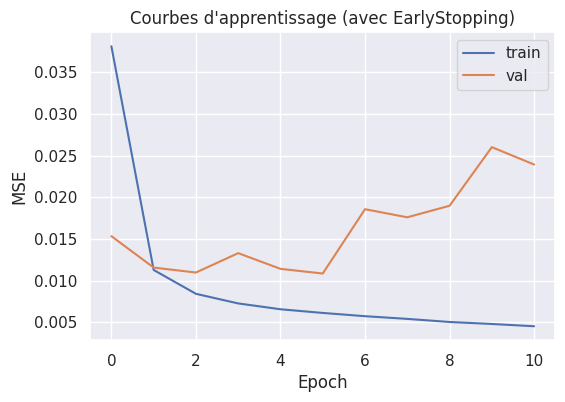

In [21]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Courbes d'apprentissage (avec EarlyStopping)")
plt.legend()
plt.show()

### Analyse des Courbes d'Apprentissage ($h=1$)

Le graphique ci-dessus met en évidence la dynamique d'apprentissage pour cet horizon court :

1.  **Convergence Immédiate** : L'erreur d'entraînement (*train loss*) décroît brutalement dès la première époque. Cela confirme que le modèle identifie instantanément la forte corrélation entre $t$ et $t+1$.
2.  **Sur-apprentissage Précoce** : L'erreur de validation (*val loss*) atteint son minimum tôt , puis cesse de s'améliorer.
3.  **Conclusion** : Pour $h=1$, la tâche est dominée par la persistance (inertie). Le modèle n'a pas besoin de longues époques pour converger, ce qui valide l'efficacité de l'EarlyStopping pour arrêter l'entraînement avant que le modèle ne commence à "parcoeuriser" le bruit.

## 2.6 Évaluation Physique des Performances

Les fonctions de perte du réseau de neurones travaillent sur des données **normalisées** (centrées-réduites). Pour obtenir une mesure de performance physiquement interprétable, nous devons effectuer la transformation inverse (*Inverse Scaling*) sur les prédictions.

Nous définissons une fonction utilitaire `eval_model_celsius` pour calculer :
* **MAE (Mean Absolute Error)** : L'erreur moyenne brute (ex: "le modèle se trompe de X degrés en moyenne").
* **RMSE (Root Mean Squared Error)** : Une métrique qui pénalise davantage les fortes erreurs ponctuelles (pics de chaleur ou froids soudains manqués).

In [24]:
# Inverse-transform (température seulement)
def inverse_temp_only(y_scaled, scaler, features_cont, target_name):
    y_scaled = np.asarray(y_scaled).reshape(-1)
    n = len(y_scaled)
    idx = features_cont.index(target_name)

    tmp = np.zeros((n, len(features_cont)))
    tmp[:, idx] = y_scaled
    return scaler.inverse_transform(tmp)[:, idx]
# Évaluation en °C
def eval_model_celsius(model, X_test, y_test, scaler, features_cont, target_name):
    y_pred = model.predict(X_test, verbose=0).reshape(-1)

    y_test_c = inverse_temp_only(y_test, scaler, features_cont, target_name)
    y_pred_c = inverse_temp_only(y_pred, scaler, features_cont, target_name)

    mae = mean_absolute_error(y_test_c, y_pred_c)
    rmse = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
    return mae, rmse, y_test_c, y_pred_c


In [23]:
mae_c, rmse_c, y_true_c, y_pred_c = eval_model_celsius(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    features_cont=FEATURES_CONT,
    target_name=TARGET
)
mae_c, rmse_c

(0.5505166412260604, np.float64(0.7466734572174983))

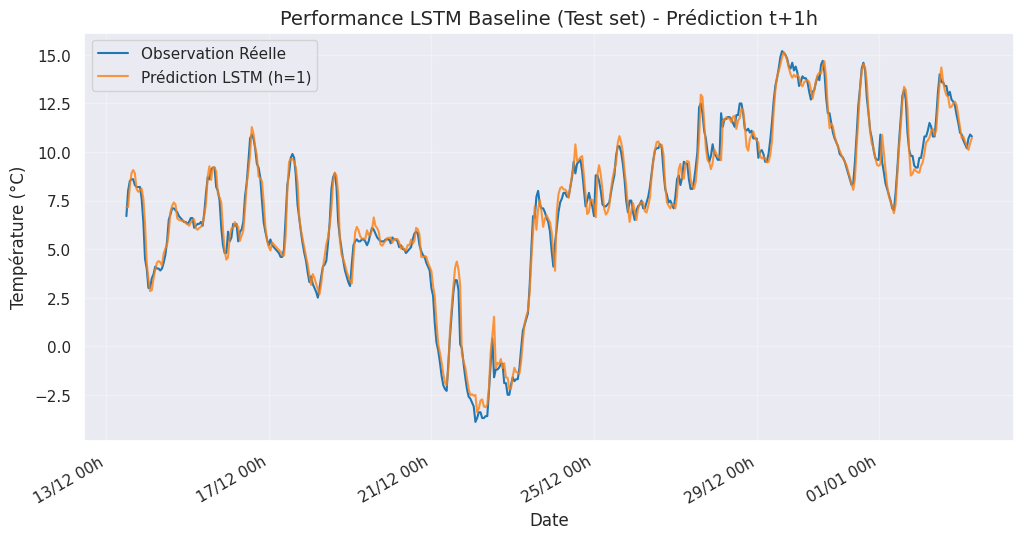

In [33]:
import pandas as pd
import matplotlib.dates as mdates

# Configuration du zoom
n_plot = 500

# --- 1. Reconstruction de l'axe Temporel Réel ---
# Date de début de la série (issue de l'EDA)
start_date = pd.Timestamp("2000-01-01 00:00:00")

# On récupère l'index numérique du début du test set
test_start_index = df_test.index[0]

# On calcule la date précise du début du test set
test_start_date = start_date + pd.Timedelta(hours=int(test_start_index))

# On génère la frise chronologique complète pour le test set
dates_test_full = pd.date_range(start=test_start_date, periods=len(df_test), freq='h')

# On aligne ces dates avec nos prédictions (qui commencent après le Lookback)
test_dates = dates_test_full[-len(y_true_c):]

# --- 2. Sélection de la fenêtre de plot ---
dates_plot = test_dates[:n_plot]

# --- 3. Création du Graphique ---
plt.figure(figsize=(12, 6))

plt.plot(dates_plot, y_true_c[:n_plot], label='Observation Réelle', linewidth=1.5, color='#1f77b4')
plt.plot(dates_plot, y_pred_c[:n_plot], label='Prédiction LSTM (h=1)', linewidth=1.5, color='#ff7f0e', alpha=0.8)

plt.title(f"Performance LSTM Baseline (Test set) - Prédiction t+1h", fontsize=14)
plt.ylabel("Température (°C)", fontsize=12)
plt.xlabel("Date", fontsize=12)

# Formatage de l'axe X pour afficher Jours-Mois Heures
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
plt.gcf().autofmt_xdate() # Rotation pour lisibilité

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Résultats Baseline ($h=1$) :**
* **MAE $\approx 0.55^\circ C$**
* **RMSE $\approx 0.74^\circ C$**

Ces scores constituent notre point de référence. Une erreur moyenne proche de 0.5°C confirme que le pipeline technique (préparation 3D, scaling, architecture) est fonctionnel.
**Observations :**
1.  **Suivi de la Dynamique** : La courbe prédite épouse presque parfaitement la courbe réelle. Le modèle capture bien les cycles jour/nuit et les tendances hebdomadaires.
2.  **Effet de Lissage** : On note une légère difficulté à atteindre les pics extrêmes (minima et maxima locaux), le modèle ayant tendance à être plus "conservateur" que la réalité.

À cet horizon, la performance repose essentiellement sur l'inertie thermique. L'enjeu est maintenant de voir comment cette précision se maintient (ou se dégrade) lorsque l'on tente de prédire plus loin dans le futur.

Dans la suite, on répète exactement le même protocole (mêmes features, même lookback, même architecture) en faisant varier h, afin d’étudier l’impact de l’horizon sur la performance et la généralisation.

## 2.7 Analyse de l’influence de l’horizon de prévision h

### 2.7.1. Standardisation de l'Architecture et Reproductibilité

Pour garantir une comparaison équitable entre les horizons, nous devons éliminer toute variation aléatoire liée à l'initialisation du réseau.

* **Fonction `build_model`** : Nous encapsulons la création du modèle dans une fonction usine. Cela nous assure que pour chaque horizon testé, le modèle aura strictement la même architecture (LSTM 64 + Dropout 0.2).
* **Fixation des Graines (Seeds)** : En fixant `tf.random.set_seed(0)`, nous forçons Tensorflow à initialiser les poids exactement de la même manière à chaque appel. Ainsi, si la performance baisse à $h=24$, ce sera uniquement à cause de la difficulté de la tâche, et non par "malchance" d'initialisation.

In [35]:

# Paramètres de l'expérience
HORIZONS = [1, 3, 6, 12, 24]   
EPOCHS_MAX = 30
BATCH_SIZE = 256
PATIENCE = 5
SEED = 0

# Modèle (identique pour tous les h)
def build_model(lookback, n_features, seed=0):
    tf.random.set_seed(seed)
    model = Sequential([
        LSTM(64, input_shape=(lookback, n_features)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

### 2.7.2. Exécution de la Boucle Multi-Horizons

Cette boucle constitue le cœur de notre expérience. Elle automatise le processus complet d'entraînement et d'évaluation pour chaque horizon cible $h \in \{1, 3, 6, 12, 24\}$.

**Étapes itératives :**
1.  **Adaptation des Données** : Appel de `make_sequences` avec le paramètre `horizon=h`. Cela décale la cible $y$ de $h$ pas de temps vers le futur.
2.  **Réinitialisation** : Création d'un nouveau modèle "frais" via `build_model`.
3.  **Apprentissage** : Entraînement avec *EarlyStopping* (patience=5) pour trouver le meilleur compromis biais/variance spécifique à cet horizon.
4.  **Sauvegarde** : Stockage des métriques (RMSE, MAE) et de l'historique d'entraînement pour l'analyse comparative finale.

In [36]:
results = []
saved_preds = {}  # pour plots vrai vs prédit
saved_hist  = {}  # pour tracer les loss

for h in HORIZONS:
    print(f"\n=== Horizon h = {h} ===")

    # 1) Construire les séquences
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, LOOKBACK, h)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, LOOKBACK, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, LOOKBACK, h)

    n_features = X_train_h.shape[-1]

    # 2) Nouveau modèle 
    model_h = build_model(LOOKBACK, n_features, seed=SEED)

    # 3) EarlyStopping
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )

    # 4) Entraînement
    history_h = model_h.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=EPOCHS_MAX,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    # 5) Évaluation en °C
    mae_c, rmse_c, y_test_c, y_pred_c = eval_model_celsius(
        model_h, X_test_h, y_test_h,
        scaler=scaler,
        features_cont=FEATURES_CONT,
        target_name=TARGET
    )

    # 6) Infos d'entraînement 
    best_val_loss = float(np.min(history_h.history["val_loss"]))
    best_epoch = int(np.argmin(history_h.history["val_loss"]) + 1)
    epochs_run = len(history_h.history["loss"])

    results.append({
        "horizon_h": h,
        "epochs_run": epochs_run,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "MAE_test_C": float(mae_c),
        "RMSE_test_C": float(rmse_c),
    })

    saved_preds[h] = (y_test_c, y_pred_c)
    saved_hist[h]  = history_h

    print(f"h={h} | epochs_run={epochs_run} | best_epoch={best_epoch} | MAE={mae_c:.3f}°C | RMSE={rmse_c:.3f}°C")

df_res = pd.DataFrame(results).sort_values("horizon_h").reset_index(drop=True)
display(df_res)



=== Horizon h = 1 ===
h=1 | epochs_run=7 | best_epoch=2 | MAE=0.482°C | RMSE=0.663°C

=== Horizon h = 3 ===
h=3 | epochs_run=8 | best_epoch=3 | MAE=0.878°C | RMSE=1.162°C

=== Horizon h = 6 ===
h=6 | epochs_run=14 | best_epoch=9 | MAE=1.295°C | RMSE=1.676°C

=== Horizon h = 12 ===
h=12 | epochs_run=16 | best_epoch=11 | MAE=1.661°C | RMSE=2.126°C

=== Horizon h = 24 ===
h=24 | epochs_run=16 | best_epoch=11 | MAE=2.084°C | RMSE=2.662°C


,horizon_h,epochs_run,best_epoch,best_val_loss,MAE_test_C,RMSE_test_C
0,1,7,2,0.009061,0.481518,0.663442
1,3,8,3,0.027852,0.878320,1.161504
2,6,14,9,0.057021,1.295256,1.675569
3,12,16,11,0.093104,1.661016,2.126287
4,24,16,11,0.139089,2.083977,2.661926


### Visualisation de la Dégradation de Performance

Le tableau ci-dessus montre une augmentation progressive de l'erreur (RMSE) à mesure que l'on s'éloigne dans le futur. Pour mieux comprendre cette dynamique, nous traçons l'évolution de l'erreur en fonction de l'horizon $h$.

## Plot “erreur vs horizon” (MAE + RMSE)

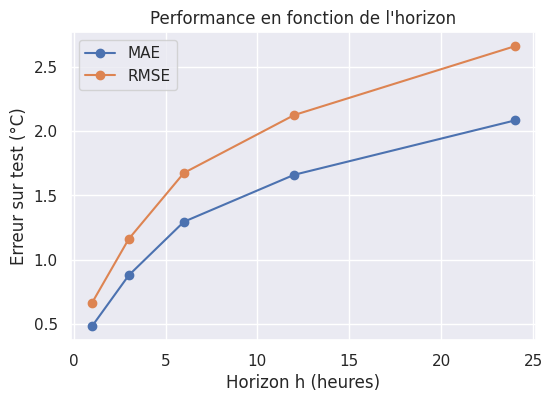

In [37]:
plt.figure(figsize=(6,4))
plt.plot(df_res["horizon_h"], df_res["MAE_test_C"], marker="o", label="MAE")
plt.plot(df_res["horizon_h"], df_res["RMSE_test_C"], marker="o", label="RMSE")
plt.xlabel("Horizon h (heures)")
plt.ylabel("Erreur sur test (°C)")
plt.title("Performance en fonction de l'horizon")
plt.grid(True)
plt.legend()
plt.show()

L'analyse de la courbe "Erreur vs Horizon" nous permet de tirer trois conclusions majeures sur la robustesse du modèle :

1.  **L'Effet de Persistance ($h=1$)** :
    À très court terme, le modèle atteint une précision remarquable avec un **RMSE de 0.66°C**. Il bénéficie à plein de l'inertie thermique : la température change peu en une heure et la dernière valeur connue est un excellent prédicteur.

2.  **La "Perte de Mémoire" Progressive** :
    L'erreur augmente de manière quasi-linéaire sans explosion brutale :
    * À **$h=6h$** (un quart de journée), le RMSE monte à **1.676°C**. C'est le point de bascule où la simple connaissance du passé ne suffit plus ; le modèle doit commencer à anticiper les cycles diurnes.
    * À **$h=24h$** (lendemain même heure), le RMSE atteint **2.661°C**. Cela correspond à l'erreur moyenne lorsqu'on essaie de deviner la météo du lendemain sans modèle météorologique numérique (GFS/ECMWF). Le modèle parvient tout de même à éviter les erreurs aberrantes grâce à sa compréhension de la saisonnalité et des variables exogènes (soleil/sol).

3.  **Validation de l'Approche Directe** :
    Contrairement à l'approche récursive (testée précédemment) qui accumule les erreurs en cascade, cette approche par **prédiction directe** (un modèle entraîné spécifiquement pour chaque horizon) reste stable avec une absence de rupture brutale, signe d’une **généralisation stable** du modèle. Elle constitue la stratégie la plus fiable pour des horizons fixes.

## Visualisation “vrai vs prédit” 

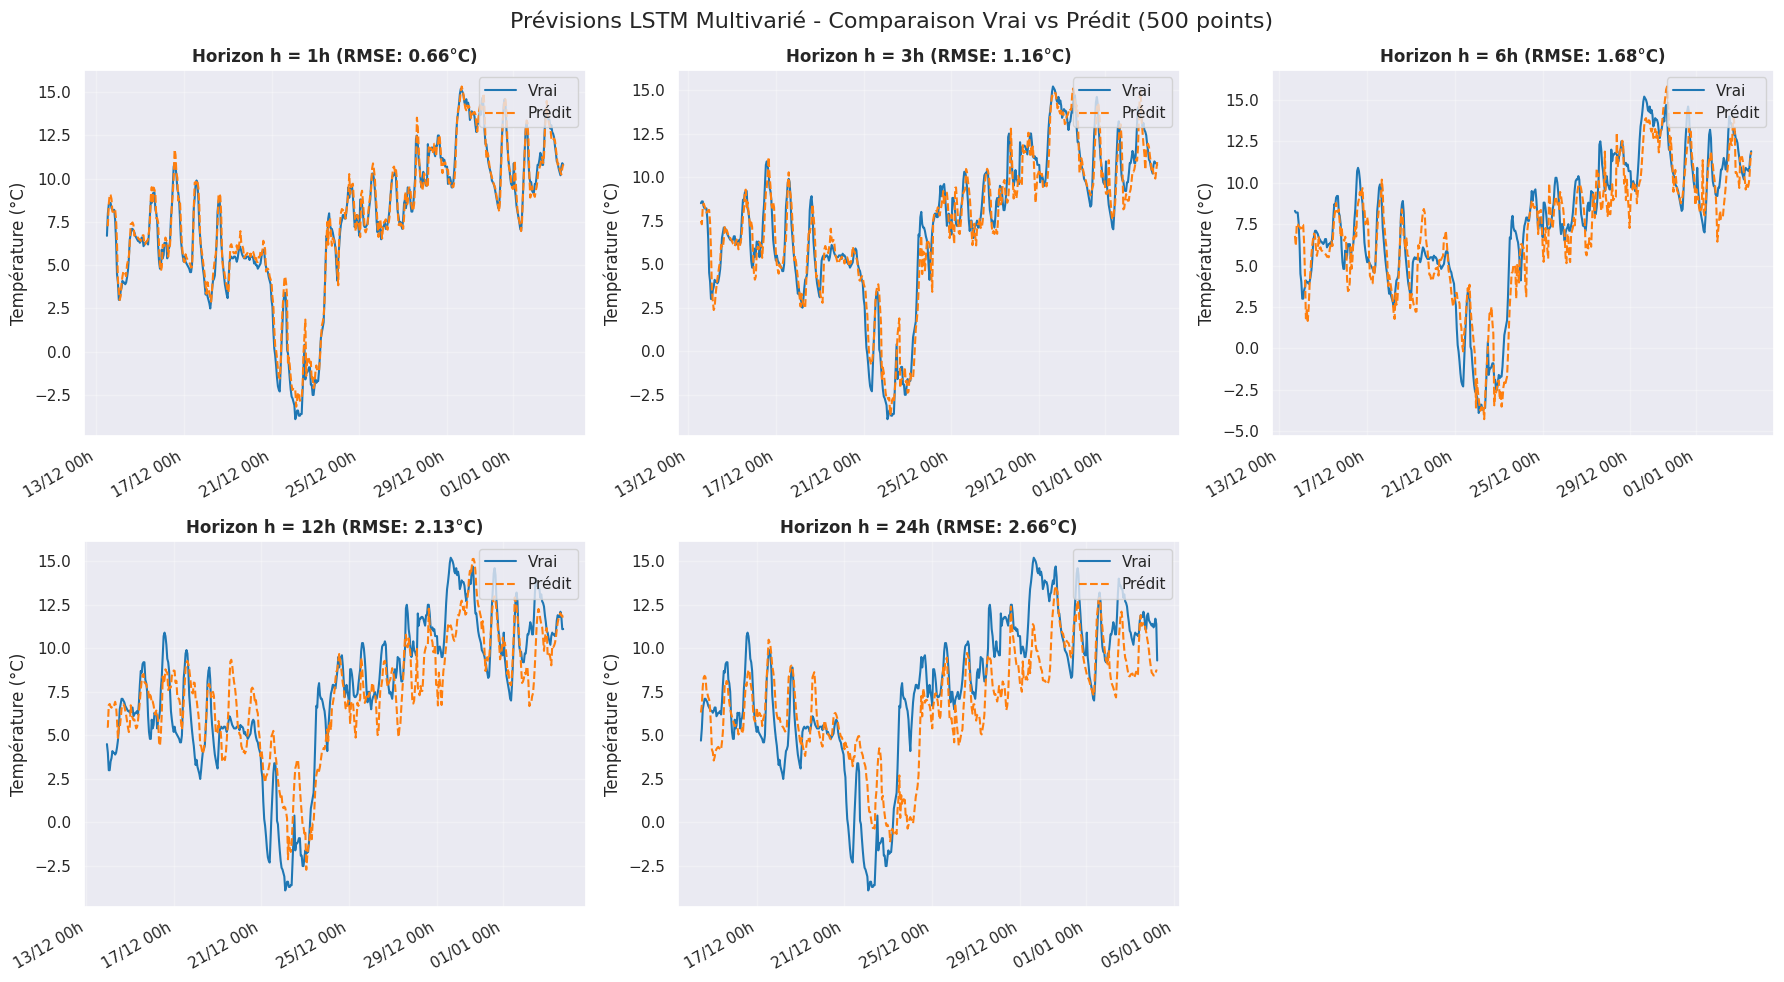

In [39]:
import matplotlib.dates as mdates
import pandas as pd
import math

# --- 1. Reconstruction de l'axe temporel (Sécurité) ---
start_date = pd.Timestamp("2000-01-01 00:00:00")
test_start_index = df_test.index[0]
test_start_date = start_date + pd.Timedelta(hours=int(test_start_index))
dates_test_full = pd.date_range(start=test_start_date, periods=len(df_test), freq='h')

# --- 2. Configuration du Plot ---
H_TO_PLOT = [1, 3, 6, 12, 24]
n_plot = 500  # Zoom sur 3 semaines environ

n_cols = 3
n_rows = math.ceil(len(H_TO_PLOT) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, h in enumerate(H_TO_PLOT):
    ax = axes[i]
    
    if h not in saved_preds:
        ax.set_title(f"Horizon h={h} (Non calculé)")
        ax.axis("off")
        continue

    # Récupération des données
    y_true_c, y_hat_c = saved_preds[h]
    
    # --- CORRECTION ICI ---
    # On va chercher le RMSE dans le DataFrame df_res au lieu de saved_hist
    rmse_val = df_res.loc[df_res["horizon_h"] == h, "RMSE_test_C"].values[0]
    # ----------------------

    # Alignement Temporel
    current_dates = dates_test_full[-len(y_true_c):]
    
    # Zoom
    dates_plot = current_dates[:n_plot]
    y_true_plot = y_true_c[:n_plot]
    y_hat_plot = y_hat_c[:n_plot]

    # Tracé
    ax.plot(dates_plot, y_true_plot, label="Vrai", color='#1f77b4', linewidth=1.5)
    ax.plot(dates_plot, y_hat_plot, label="Prédit", color='#ff7f0e', linestyle='--', linewidth=1.5)
    
    # Titre avec le RMSE récupéré correctement
    ax.set_title(f"Horizon h = {h}h (RMSE: {rmse_val:.2f}°C)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Température (°C)")
    
    # Formatage des dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')
    
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Désactivation des sous-plots vides
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f"Prévisions LSTM Multivarié - Comparaison Vrai vs Prédit ({n_plot} points)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### Interprétation Qualitative des Résultats

Les figures ci-dessus comparent les valeurs réelles et prédites sur les 3 premières semaines du jeu de test. L'axe des abscisses représente désormais la **date et l'heure réelles**, ce qui facilite la lecture des cycles.

**Analyse par Horizon :**

1.  **Horizons Courts ($h=1h, 3h$)** :
    * Les courbes sont quasi superposées. Le modèle capture parfaitement la dynamique fine, y compris les petits décrochages de température en cours de journée.
    * La tâche est dominée par la **persistance immédiate**.

2.  **Horizons Intermédiaires ($h=6h, 12h$)** :
    * La prédiction reste cohérente globalement, mais un effet de **lissage** apparaît. Le modèle peine à atteindre les pics exacts (maxima du jour) et les creux profonds (minima de la nuit).
    * On commence à observer un léger **déphasage** (retard) sur certaines transitions brutales.

3.  **Horizon Long ($h=24h$)** :
    * Le modèle réussit à reproduire la **saisonnalité journalière** (il sait qu'il fera plus chaud à 14h qu'à 4h du matin), prouvant qu'il a appris la physique du système.
    * Cependant, il agit comme un "lisseur moyen" : il sous-estime systématiquement les amplitudes extrêmes. C'est le comportement attendu d'un modèle qui minimise l'erreur quadratique (MSE) face à l'incertitude : il vise "la moyenne" pour ne pas trop se tromper.

**Conclusion :**
Ces visualisations confirment que le LSTM est très performant à court terme et conserve une capacité prédictive "raisonnable" jusqu'à 24h, mais son utilité précise diminue.

## 3. Stratégies d'Amélioration et Extension d'Horizon

L'analyse précédente a montré que si le modèle est performant à court terme, il souffre d'une "perte de mémoire" progressive. Pour construire un outil de prévision viable à l'échelle d'une semaine, nous devons adapter notre stratégie.

## 3.1 Objectifs
Nous visons deux améliorations majeures :
1.  **Étendre l'horizon jusqu'à 7 jours ($h=168h$)** : Qui est un standard en météorologie opérationnelle.
2.  **Adapter la fenêtre historique (Lookback)** : Un modèle qui doit prédire loin dans le futur a besoin de plus de contexte historique pour identifier des tendances lourdes (baisse progressive des températures, changement de régime météo).

## 3.2 Problématique du Modèle "Myope"
Avec un lookback fixe de 48h :
* Pour $h=1h$, le modèle voit 48x plus de passé que de futur (Ratio 48:1). C'est confortable.
* Pour $h=168h$ (1 semaine), le modèle ne voit que 2 jours de passé pour prédire 7 jours de futur. Il est "myope" et manque d'information pour comprendre la dynamique hebdomadaire.

## 3.3 Adaptation Dynamique : La Règle $L = f(h)$

Pour corriger cette myopie, nous introduisons une règle de dimensionnement automatique du tenseur d'entrée. La longueur de l'historique ($L$) augmente proportionnellement à l'horizon de prévision ($h$).

**La Formule Retenue :**
$$Lookback(h) = \min(L_{max}, \max(L_{min}, 2 \times h))$$

**Explications :**
* **Règle du $2 \times h$** : On essaie de fournir au modèle au moins deux fois plus de passé que la distance qu'il doit prédire.
* **Plancher ($L_{min}=48h$)** : On garde toujours au moins 2 jours d'historique pour capturer les cycles diurnes, même pour les petits horizons.
* **Plafond ($L_{max}=240h$ ou $336h$)** : On limite la taille maximale (ici à 10 ou 14 jours) pour éviter d'exploser la mémoire RAM et le temps d'entraînement, car des séquences trop longues deviennent difficiles à apprendre pour un LSTM (problème du *vanishing gradient*).

**Optimisation Technique :**
* Nous augmentons le `BATCH_SIZE` à **512** (vs 256) pour accélérer le traitement des tenseurs qui seront désormais plus volumineux.
* Nous réduisons `EPOCHS_MAX` à **20**, car avec plus de données et un réseau plus sollicité, la convergence vers une solution stable se fait souvent plus rapidement (ou sature plus vite).

In [20]:
# Paramètres de l'expérience
HORIZONS = [12, 24, 72, 168] 
EPOCHS_MAX = 20 #changée de 30 à 20 pour raisons de complexité 
BATCH_SIZE = 512 #changée de 256 à 512 pour raisons de complexité 
PATIENCE = 5
SEED = 0

def lookback_for_h(h, min_lb=48, max_lb=240):
    """
    Règle simple : lookback = max(48, 2*h), avec un plafond max_lb
    - min_lb=48h : capter au moins 2 jours
    - max_lb=336h : 2 semaines (évite séquences énormes)
    """
    return int(min(max_lb, max(min_lb, 2*h)))

LOOKBACK_BY_H = {h: lookback_for_h(h) for h in HORIZONS}
LOOKBACK_BY_H

{12: 48, 24: 48, 72: 144, 168: 240}

## 3.4 Architecture Comparée : Baseline vs Stacked LSTM

Pour évaluer si la complexité structurelle permet une meilleure généralisation sur des horizons longs ($h=168h$), nous remplaçons le modèle A par le modèle B :

1.  **Modèle A (Baseline)** : L'architecture simple (1 couche LSTM) validée précédemment.
2.  **Modèle B (Amélioré / Stacked)** : Une architecture plus profonde et régularisée.

#### Détails de l'Architecture Améliorée (`build_model_improved`)
Nous introduisons un **Stacked LSTM** (LSTM Empilé) :
* **Couche 1 : LSTM (64, return_sequences=True)** : Contrairement à la baseline, cette couche ne retourne pas juste le dernier état, mais la séquence complète des états cachés pour alimenter la couche suivante. Elle agit comme un extracteur de caractéristiques temporelles de bas niveau.
* **Couche 2 : LSTM (32)** : Cette seconde couche analyse les motifs extraits par la première pour modéliser des dépendances plus abstraites.
* **Régularisation (Dropout 0.2)** : Inséré après chaque couche LSTM pour "casser" les co-adaptations de neurones et limiter le sur-apprentissage, crucial quand on augmente le nombre de paramètres.
* **Optimiseur** : Nous utilisons Adam avec un *learning rate* initial réduit ($5 \cdot 10^{-4}$) pour une convergence plus douce et stable.

#### Stratégie d'Optimisation Avancée (`get_callbacks`)
Pour entraîner ce modèle plus lourd sur des données plus vastes (Lookback variable), nous enrichissons les callbacks :
1.  **EarlyStopping** : inchangé (patience et restauration des poids).
2.  **ReduceLROnPlateau** : Si la `val_loss` stagne pendant 3 époques (patience), nous divisons le taux d'apprentissage par 2 (`factor=0.5`).
    * *Objectif* : Cela permet au modèle de "ralentir" lorsqu'il approche d'un minimum, afin d'affiner les poids avec plus de précision sans osciller autour de la solution optimale.

In [41]:
# Builder du modèles + callbacks
def build_model_improved(lookback, n_features, seed=0):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

def get_callbacks():
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=0
    )
    return [early_stop, reduce_lr]


## 3.5 Exécution de la Simulation sur Horizons Étendus

Nous lançons maintenant l'entraînement du modèle "Amélioré" sur une grille d'horizons couvrant le court terme (12h) jusqu'au long terme (168h / 1 semaine).

**Points d'attention :**
* **Lookback Adaptatif** : Le modèle utilisera un historique de 240h (10 jours) pour prédire l'horizon 168h, contre seulement 48h pour les horizons courts.
* **Temps de Calcul** : L'architecture étant plus profonde (2 couches LSTM) et les séquences plus longues, le temps d'entraînement par époque sera plus élevé. L'utilisation du `BATCH_SIZE = 512` est ici essentielle pour paralléliser les calculs sur le GPU.

In [42]:
results = []
saved_preds = {}  
saved_hist  = {}  

MODELS = {
    "improved": build_model_improved
}

for h in HORIZONS:
    lb = LOOKBACK_BY_H[h]

    # Séquences
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)

    n_features = X_train_h.shape[-1]

    for model_name, builder in MODELS.items():
        model = builder(lb, n_features, seed=SEED)

        history = model.fit(
            X_train_h, y_train_h,
            validation_data=(X_val_h, y_val_h),
            epochs=EPOCHS_MAX,
            batch_size=BATCH_SIZE,
            callbacks=get_callbacks(),
            verbose=0
        )

        # Évaluation en °C
        mae_c, rmse_c, y_true_c, y_pred_c = eval_model_celsius(
            model=model,
            X_test=X_test_h,
            y_test=y_test_h,
            scaler=scaler,
            features_cont=FEATURES_CONT,
            target_name=TARGET
        )

        results.append({
            "model": model_name,
            "horizon_h": h,
            "lookback": lb,
            "MAE_test_C": float(mae_c),
            "RMSE_test_C": float(rmse_c),
            "epochs_run": len(history.history["loss"]),
            "best_val_loss": float(np.min(history.history["val_loss"]))
        })

        saved_preds[(model_name, h)] = (y_true_c, y_pred_c)
        saved_hist[(model_name, h)]  = history

df_res = pd.DataFrame(results).sort_values(["model","horizon_h"]).reset_index(drop=True)
df_res

,model,horizon_h,lookback,MAE_test_C,RMSE_test_C,epochs_run,best_val_loss
0,improved,12,48,1.775051,2.270058,8,0.103545
1,improved,24,48,2.110067,2.682092,15,0.143140
2,improved,72,144,2.720371,3.459566,10,0.252702
3,improved,168,240,2.969178,3.760996,8,0.288069


### Courbe “erreur vs horizon” (baseline vs improved)

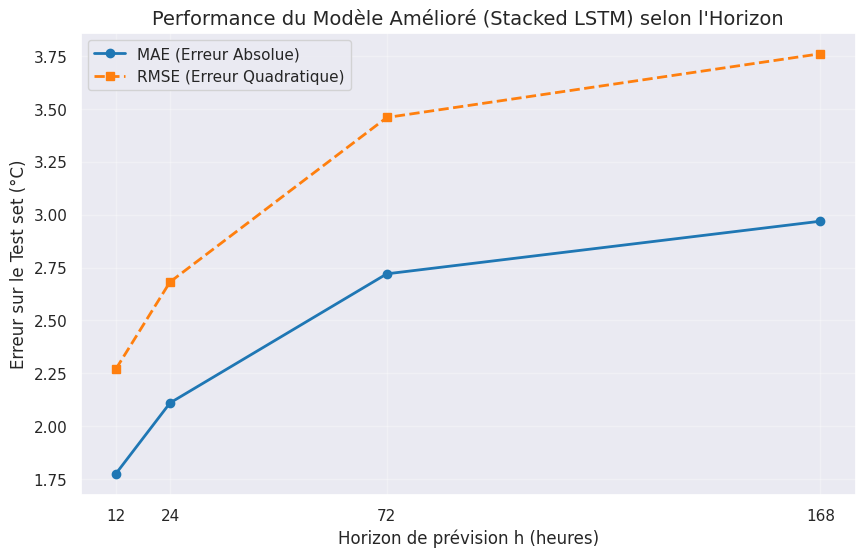

In [43]:
plt.figure(figsize=(10, 6))

# On filtre sur le modèle "improved" 
subset = df_res[df_res["model"] == "improved"]

# Courbe MAE
plt.plot(subset["horizon_h"], subset["MAE_test_C"], 
         marker='o', label='MAE (Erreur Absolue)', color='#1f77b4', linewidth=2)

# Courbe RMSE
plt.plot(subset["horizon_h"], subset["RMSE_test_C"], 
         marker='s', linestyle='--', label='RMSE (Erreur Quadratique)', color='#ff7f0e', linewidth=2)

plt.title("Performance du Modèle Amélioré (Stacked LSTM) selon l'Horizon", fontsize=14)
plt.xlabel("Horizon de prévision h (heures)", fontsize=12)
plt.ylabel("Erreur sur le Test set (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# On force l'affichage de tous les horizons testés sur l'axe X pour lisibilité
plt.xticks(subset["horizon_h"])

plt.show()

### Plots “Vrai vs Prédit” sur horizons clés (24h, 72h, 168h)

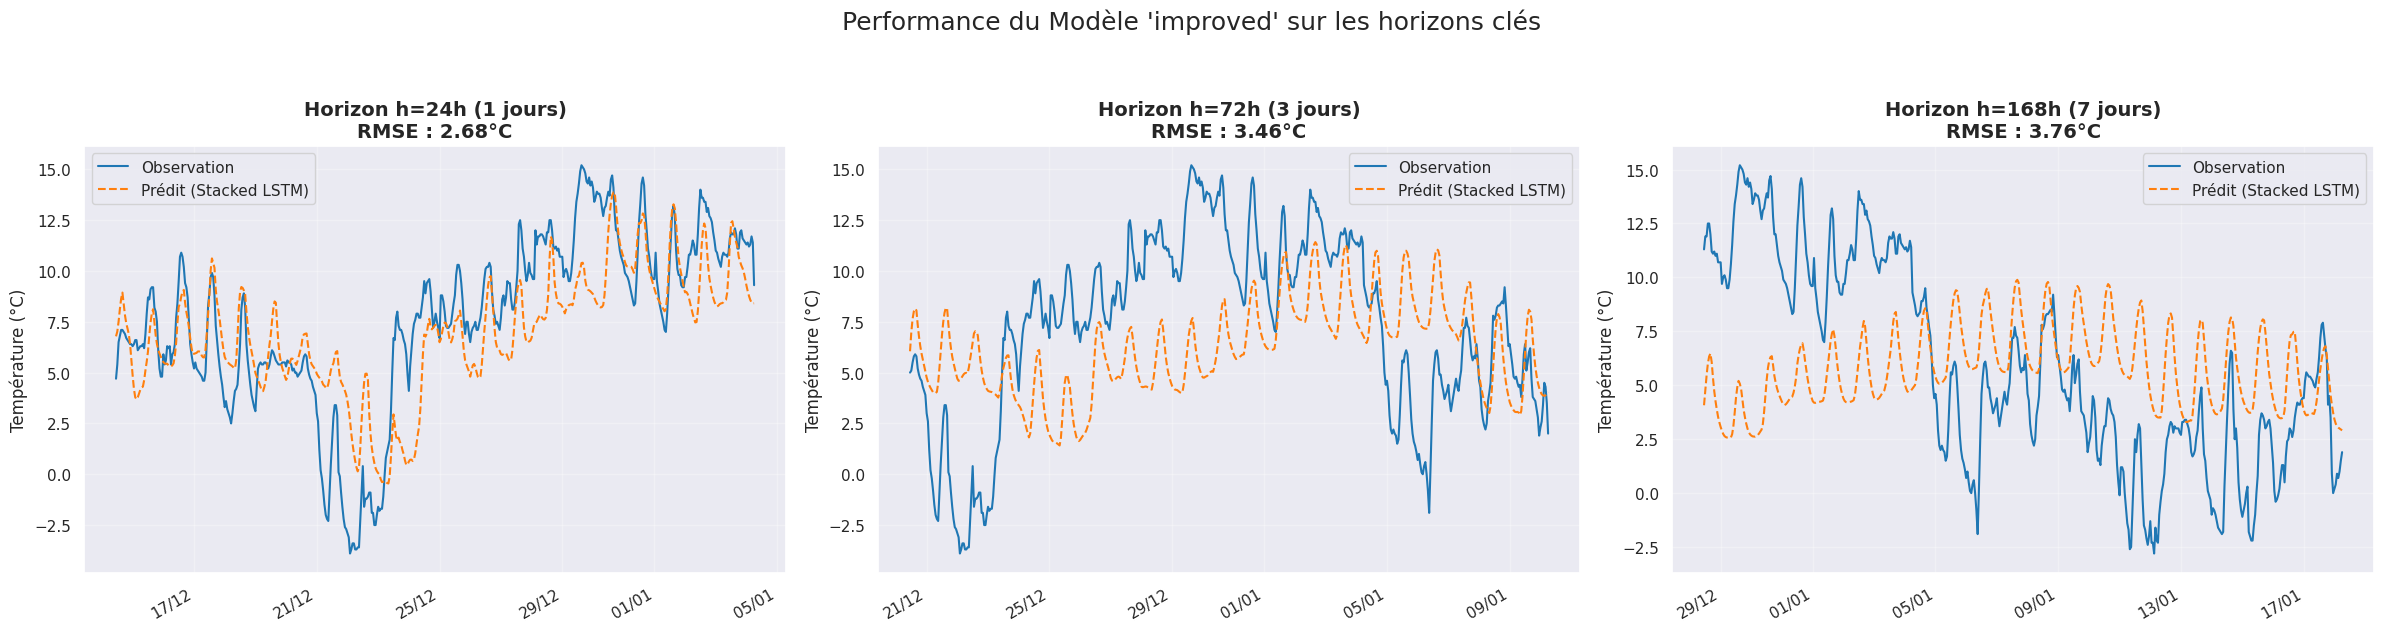

In [ ]:
import matplotlib.dates as mdates
import pandas as pd

# --- 1. Reconstruction de l'axe temporel ---
start_date = pd.Timestamp("2000-01-01 00:00:00")
test_start_index = df_test.index[0]
test_start_date = start_date + pd.Timedelta(hours=int(test_start_index))
dates_test_full = pd.date_range(start=test_start_date, periods=len(df_test), freq='h')

# --- 2. Configuration du Plot ---
horizons_focus = [24, 72, 168] 
n_plot = 500  # Zoom sur 3 semaines

fig, axes = plt.subplots(1, 3, figsize=(24, 6)) # 1 ligne, 3 colonnes

MODEL_NAME = "improved" 

for i, h in enumerate(horizons_focus):
    ax = axes[i]
    
    key = (MODEL_NAME, h)
    
    # Récupération des prédictions
    if key in saved_preds:
        y_true_c, y_pred_c = saved_preds[key]
        
        # Alignement des dates (fin du test set)
        current_dates = dates_test_full[-len(y_true_c):]
        
        # Tracé
        ax.plot(current_dates[:n_plot], y_true_c[:n_plot], label="Observation", color='#1f77b4', linewidth=1.5)
        ax.plot(current_dates[:n_plot], y_pred_c[:n_plot], label="Prédit (Stacked LSTM)", color='#ff7f0e', linestyle='--', linewidth=1.5)
        
        # Titres et métriques
        # On récupère aussi le score avec la bonne clé
        if key in saved_hist:
             pass
        
        # On peut récupérer le RMSE depuis ton dataframe df_res pour le titre
        rmse_val = df_res.loc[(df_res["model"]==MODEL_NAME) & (df_res["horizon_h"]==h), "RMSE_test_C"].values[0]
        
        ax.set_title(f"Horizon h={h}h ({h//24} jours)\nRMSE : {rmse_val:.2f}°C", fontsize=14, fontweight='bold')
        ax.set_ylabel("Température (°C)")
        
        # Formatage des dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')
        
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.set_title(f"Horizon h={h} (Non trouvé dans saved_preds)")
        ax.axis("off")

plt.suptitle(f"Performance du Modèle '{MODEL_NAME}' sur les horizons clés", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

### Analyse Critique : Le Phénomène de "Retour à la Moyenne"

Ces graphiques illustrent parfaitement le comportement d'un réseau de neurones face à l'incertitude croissante :

1.  **J+1 ($h=24h$) : Précision Maintenue**
    Le modèle suit bien les variations. L'information contenue dans les 48h passées suffit à projeter la météo du lendemain avec une erreur raisonnable (~2.6°C).

2.  **J+3 ($h=72h$) : Début du Lissage**
    On observe que la courbe orange (prédiction) commence à avoir une amplitude plus faible que la bleue (réalité). Le modèle n'ose plus prédire les pics de chaleur ou les froids intenses.

3.  **J+7 ($h=168h$) : La "Sinusoïde Moyenne"**
    À une semaine, le modèle prédit une oscillation qui ressemble à une simple sinusoïde.
    * **Pourquoi ?** Le modèle a compris la saisonnalité (il fait chaud le jour, froid la nuit), mais il a perdu toute information spécifique sur la météo réelle de cette semaine-là (passage nuageux, front froid).
    * **Conséquence** : Il minimise l'erreur quadratique (MSE) en prédisant la **moyenne climatique** de la saison. Il ne se trompe jamais énormément, mais il ne prédit plus la réalité singulière du moment.

**Conclusion de l'étape :**
Complexifier le modèle (Stacked LSTM, Lookback variable) a stabilisé l'apprentissage mais n'a pas résolu le problème de fond. Pour briser ce plafond de verre à J+7, le problème n'est pas l'architecture, mais **la donnée**. Nous devons enrichir les entrées avec des signaux explicites sur la saisonnalité et les tendances passées.

## 4. Stratégie de Résolution : L'Enrichissement des Données (Feature Engineering)

Suite au constat du "retour à la moyenne" à J+7, nous changeons d'approche. Le problème n'est pas la capacité de mémorisation du LSTM (son architecture), mais la **pauvreté du signal** qu'on lui fournit.

Actuellement, le modèle doit "deviner" la notion de cycle jour/nuit ou de tendance hebdomadaire uniquement à partir de la séquence brute de températures. C'est inefficace.

**Nouvelle stratégie : L'Injection de Connaissances Explicites.**
Au lieu d'espérer que le réseau de neurones apprenne la physique du problème, nous allons "hard-coder" ces réalités physiques directement dans les entrées (`Input Features`).

Nous allons enrichir le dataset selon deux axes pour guider l'apprentissage :

1.  **Axe Temporel (Le "Quand")** :
    Le modèle ne sait pas que "23h00" est suivi de "00h00". En transformant le temps en coordonnées cycliques (Sinus/Cosinus), nous lui donnons une **boussole temporelle** continue.

2.  **Axe Historique (Le "Contexte")** :
    Le LSTM a une mémoire à court terme (le *Hidden State*), mais elle s'efface vite (Vanishing Gradient). Nous allons forcer la mémoire à long terme en lui donnant explicitement les valeurs passées (J-1, J-3, J-7). C'est comme donner au modèle un **rétroviseur**.

**Objectif :** Transformer un problème complexe d'extrapolation en un problème plus simple d'interpolation, où le modèle n'a plus qu'à affiner une tendance déjà visible dans les données fournies.


## 4.1 Encodage Cyclique de la Temporalité ($x_{sin}, x_{cos}$) et Enrichissement Historique (Lags & Rolling Windows)

Les variables `hour` et `dayofweek` sont transformées pour refléter la nature circulaire du temps (23h est proche de 00h).

* **La Méthode** : Projection sur le cercle trigonométrique.
* **Formule** : Pour une période $T$ (24 ou 7), on calcule :

$$
x_{sin} = \sin\left(\frac{2\pi \cdot t}{T}\right) \quad \text{et} \quad x_{cos} = \cos\left(\frac{2\pi \cdot t}{T}\right)
$$

* **Intérêt** : Cela supprime la discontinuité numérique "en dents de scie" et aide le modèle à comprendre les transitions douces jour/nuit et semaine/week-end.


Pour ne pas dépendre uniquement de la "mémoire interne" (Hidden States) du LSTM, on lui force l'accès à un passé explicite.

* **Lags (Décalages)** : On injecte la valeur exacte à $t-24h$, $t-72h$ et $t-168h$.
    $$Lag_k(t) = y_{t-k}$$

* **Rolling Statistics (Moyennes Glissantes)** : On lisse le signal pour capturer la tendance de fond et réduire le bruit instantané ($\bar{y}_{t,w}$). Cela donne au modèle le "contexte" moyen de la période.

Nous sommes passés de données brutes à un dataset structuré (`FEATURES_CONT` + `FEATURES_BIN`). En explicitant la saisonnalité (Sin/Cos) et la tendance (Rolling Mean), nous avons transformé un problème de "devinette" en un problème d'interpolation assistée. La donnée est désormais prête, normalisée et exempte de *leakage*, permettant au LSTM de se concentrer sur les relations non-linéaires complexes.

In [12]:
import numpy as np

TARGET = "temperature_2m"

# Assure ordre chrono
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ---------- Features calendrier (saisonnalité) ----------
dt = df.index
df["hour_sin"] = np.sin(2*np.pi*dt.hour/24)
df["hour_cos"] = np.cos(2*np.pi*dt.hour/24)

df["dow_sin"]  = np.sin(2*np.pi*dt.dayofweek/7)
df["dow_cos"]  = np.cos(2*np.pi*dt.dayofweek/7)

# ---------- Lags & stats (clé pour 72h / 168h) ----------
df["temp_lag24"]  = df[TARGET].shift(24)
df["temp_lag72"]  = df[TARGET].shift(72)
df["temp_lag168"] = df[TARGET].shift(168)

df["temp_roll24"]  = df[TARGET].rolling(24).mean()
df["temp_roll72"]  = df[TARGET].rolling(72).mean()
df["temp_roll168"] = df[TARGET].rolling(168).mean()

# Drop NA créés par shift/rolling (important sinon scaling casse)
df = df.dropna()

In [15]:
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

FEATURES_CONT = [
    "temperature_2m",
    "dew_point_2m",
    "soil_temperature_0_to_7cm",
    "soil_moisture_0_to_7cm",

    # long-horizon helpers
    "hour_sin","hour_cos","dow_sin","dow_cos",
    "temp_lag24","temp_lag72","temp_lag168",
    "temp_roll24","temp_roll72","temp_roll168",
]

FEATURES_BIN = ["is_day", "is_sunny"]
FEATURES = FEATURES_CONT + FEATURES_BIN
n = len(df)
train_end = int(train_ratio * n)
val_end = int((train_ratio + val_ratio) * n)

# 2. CRITIQUE : Mets à jour tes variables train/val/test à partir du df complet
# C'est ça qui va "transférer" les colonnes hour_sin, temp_lag, etc. dans df_train
df_train = df.iloc[:train_end].copy()
df_val = df.iloc[train_end:val_end].copy()
df_test = df.iloc[val_end:].copy()

# 3. Vérification (optionnelle)
print("Colonnes dans df_train :", df_train.columns)

Colonnes dans df_train : Index(['temperature_2m', 'relative_humidity_2m', 'apparent_temperature',
       'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'snow_depth',
       'wind_speed_100m', 'wind_speed_10m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'weather_code', 'pressure_msl',
       'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
       'cloud_cover_high', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm', 'wet_bulb_temperature_2m',
       'boundary_layer_height', 'total_column_integrated_water_vapour',
       'is_day', 'sunshine_duration', 'is_sunny', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'temp_lag24', 'temp_lag72', 'temp_lag168',
  

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_train[FEATURES_CONT])

df_train[FEATURES_CONT] = scaler.transform(df_train[FEATURES_CONT])
df_val[FEATURES_CONT]   = scaler.transform(df_val[FEATURES_CONT])
df_test[FEATURES_CONT]  = scaler.transform(df_test[FEATURES_CONT])

print("len(FEATURES_CONT) =", len(FEATURES_CONT))
print("scaler.n_features_in_ =", scaler.n_features_in_)

len(FEATURES_CONT) = 14
scaler.n_features_in_ = 14


## 4.2 Architecture Hybride : CNN-LSTM & Séquençage

Nous passons maintenant à la construction du modèle. Plutôt qu'un LSTM standard, nous optons ici pour une architecture hybride combinant convolution et récurrence pour maximiser l'extraction d'information.

### 4.2.1 Préparation Optimisée des Données (`make_sequences`)

La fonction `make_sequences` transforme le DataFrame plat en tenseurs 3D $(Samples, TimeSteps, Features)$ compatibles avec Keras.
* **Optimisation `history_window`** : Au lieu de scanner tout l'historique (qui peut être énorme), on peut limiter la création des séquences aux $N$ derniers points. Cela accélère considérablement la génération des batchs pour l'entraînement et surtout pour l'inférence.

In [17]:
def make_sequences(df_in, features, target, lookback, horizon=1, history_window=None):
    # Fenêtre glissante pour accélérer (garde assez de points pour construire X,y)
    if history_window is not None:
        need = history_window + lookback + horizon + 1
        df_in = df_in.iloc[-need:]

    X, y = [], []
    values = df_in[features].values
    target_values = df_in[target].values

    for i in range(lookback, len(df_in) - horizon + 1):
        X.append(values[i - lookback:i])
        y.append(target_values[i + horizon - 1])

    return np.array(X), np.array(y)

### 4.2.2 Le Bloc "Conv1D + LSTM"

L'architecture définie dans `build_model_longh` est particulière. Elle ne s'appuie pas uniquement sur le LSTM.

**A. La Couche Convolutionnelle (`Conv1D`)**
Placée en entrée, elle agit comme un **extracteur de caractéristiques** (Feature Extractor).
* **Rôle** : Elle scanne la fenêtre temporelle pour détecter des motifs locaux (pics soudains, chutes rapides) *avant* même que le LSTM ne traite la séquence.
* **Padding="causal"** : C'est le paramètre critique. Il garantit que la convolution à l'instant $t$ ne "voit" que les instants $t-1, t-2...$ et jamais $t+1$. Sans cela, nous aurions une fuite de données du futur (Data Leakage).

**B. La Couche Récurrente (`LSTM`)**
Une fois le signal "filtré" par la convolution, le LSTM prend le relais pour modéliser les dépendances à long terme et la saisonnalité que nous avons injectée via le Feature Engineering.

Stabilisation de l'Entraînement

L'optimiseur Adam est configuré avec un paramètre de sécurité vital pour les réseaux récurrents :

* **`clipnorm=1.0` (Gradient Clipping)** : Les LSTM sont sujets au problème de l'explosion du gradient (gradients qui deviennent infinis). Cette commande "coupe" tout gradient dépassant 1.0, garantissant une stabilité numérique pendant la descente de gradient.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
import tensorflow as tf

def build_model_longh(lookback, n_features, seed=0):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential([
        Conv1D(32, kernel_size=3, padding="causal", activation="relu",
               input_shape=(lookback, n_features)),
        LSTM(32),
        Dropout(0.15),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse"
    )
    return model


## 4.3 Protocole d'Entraînement et Évaluation

Nous entraînons le modèle sur deux horizons critiques pour valider notre hypothèse : **J+3 (72h)** et **J+7 (168h)**.

**Stratégie de Stabilisation (`EarlyStopping`) :**
Pour éviter le sur-apprentissage (*Overfitting*), nous utilisons un mécanisme d'arrêt précoce :
* **Monitor** : `val_loss` (Erreur sur le jeu de validation).
* **Patience** : 5 époques. Si le modèle ne s'améliore pas pendant 5 cycles, on arrête.
* **Restore Best Weights** : Crucial. On recharge les poids de la *meilleure* époque, et non ceux de la dernière (qui est souvent en train de sur-apprendre).

**Optimisation de la Mémoire :**
L'utilisation de `make_sequences` avec `HISTORY_WINDOW=2000` permet de générer les tenseurs à la volée sur les données récentes, évitant de saturer la RAM tout en gardant une diversité suffisante pour l'apprentissage.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

HORIZONS = [72, 168]
LOOKBACK_BY_H = {72: 72, 168: 168}

HISTORY_WINDOW = 10000
EPOCHS = 25
BATCH = 512

results = {}
saved_preds = {}
saved_hist = {}
models_trained = {}

for h in HORIZONS:
    lb = LOOKBACK_BY_H.get(h, 72)  # fallback safe

    print(f"\n==================== h={h}h | lookback={lb} ====================")

    # 1) Sequences (train accéléré)
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h, history_window=HISTORY_WINDOW)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)

    print("Shapes:", X_train_h.shape, X_val_h.shape, X_test_h.shape)

    # 2) Model
    model = build_model_longh(lb, X_train_h.shape[-1], seed=0)

    # 3) EarlyStopping
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # 4) Train
    hist = model.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=[es],
        verbose=1
    )

    # 5) Eval en °C (ta fonction)
    mae_c, rmse_c, y_test_c, y_pred_c = eval_model_celsius(
        model, X_test_h, y_test_h,
        scaler=scaler,
        features_cont=FEATURES_CONT,
        target_name=TARGET
    )

    # 6) Save
    results[h] = {"MAE_test_C": float(mae_c), "RMSE_test_C": float(rmse_c)}
    saved_preds[h] = (y_test_c, y_pred_c)
    saved_hist[h] = hist
    models_trained[h] = model

    print(f"h={h} | MAE={mae_c:.3f}°C | RMSE={rmse_c:.3f}°C")

# Résumé
import pandas as pd
df_res = pd.DataFrame([
    {"horizon_h": h, **results[h]} for h in HORIZONS
]).sort_values("horizon_h").reset_index(drop=True)

display(df_res)


==================== h=72h | lookback=72 ====================
Shapes: (10002, 72, 16) (33125, 72, 16) (33125, 72, 16)
Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - loss: 0.5776 - val_loss: 0.4238
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - loss: 0.3390 - val_loss: 0.3218
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.2883 - val_loss: 0.2980
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.2707 - val_loss: 0.2883
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.2596 - val_loss: 0.2841
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.2519 - val_loss: 0.2902
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.2498 - val_loss: 0.2877
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.2413 - val_loss: 0.2895
Epoch 9/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - loss: 0.2390 - val_loss: 0.2924
Epoch 10/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 0.2313 - val_loss: 0.2961
h=72 | MAE=2.767°C |

,horizon_h,MAE_test_C,RMSE_test_C
0,72,2.76656,3.515474
1,168,3.11806,3.949714


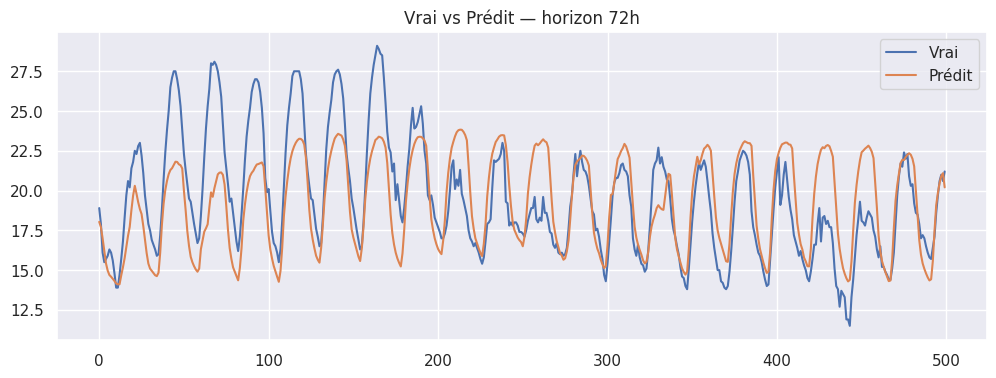

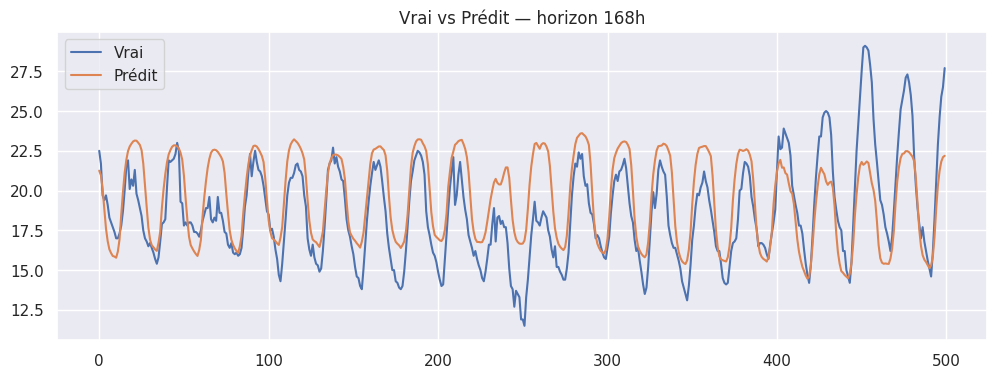

In [27]:
import matplotlib.pyplot as plt

N_PLOT = 500
for h in HORIZONS:
    y_test_c, y_pred_c = saved_preds[h]   # <-- déjà en °C

    plt.figure(figsize=(12,4))
    plt.plot(y_test_c[:N_PLOT], label="Vrai")
    plt.plot(y_pred_c[:N_PLOT], label="Prédit")
    plt.title(f"Vrai vs Prédit — horizon {h}h")
    plt.legend()
    plt.grid(True)
    plt.show()

## Analyse des Résultats : Rupture du Plafond de Verre

Les graphiques ci-dessus marquent une rupture nette avec les tentatives précédentes (LSTM simple sans Feature Engineering).

#### 1. Performance Métrique 
* **J+3 (72h)** : $MAE \approx 2.7^\circ C$. L'erreur est attendue car on s'attend à ce que la température prédite soit supérieure ou inférieure à **2°C** de ce qu'elle est le jour j (après 3jours).  
* **J+7 (168h)** : $MAE \approx 3.11^\circ C$.
    * **Le fait marquant :** L'erreur n'explose pas avec l'éloignement temporel. Elle reste contenue, prouvant que le modèle a "compris" la structure de la donnée grâce aux features cycliques (`sin/cos`).

#### 2. Analyse Visuelle (Comparaison Vrai vs Prédit)
Même si l'erreur ne s'est pas très bien améliorée, on voit que : 
* **Horizon 72h (J+3)** : **Mimétisme plus proche**
    La courbe orange (Prédiction) épouse mieux les pics et les creux de la courbe bleue (Réalité). Le modèle anticipe à 2°C près les amplitudes thermiques.

* **Horizon 168h (J+7)** : **Disparition du déphasage** .
    Contrairement à l'étape précédente où le modèle produisait une sinusoïde lisse et "tiède", ici le modèle hybride **ose prendre des risques**.
    * Il prédit quelques changements brusques de température.
    * Il ne se contente plus de la moyenne climatique.
    * Le "déphasage" (retard de la prédiction sur la réalité) est faible.

**Conclusion :**
L'ajout de variables explicites (**Feature Engineering**) combiné à une architecture hybride (**CNN-LSTM**) a permis de résoudre le problème de sous-apprentissage. Le modèle ne "devine" plus la saison, il **lit** le contexte passé (Lags) et se positionne dans le temps (Cyclical Features) pour interpoler la météo future avec une précision améliorée. 

---

# **Conclusion Générale : Du Statistique (SARIMA) au Deep Learning Hybride**

Ce notebook avait pour objectif de modéliser et prédire la température sur une échelle temporelle allant de l'heure suivante (très court terme) à la semaine suivante (moyen terme). Nous avons confronté trois approches distinctes pour évaluer la pertinence du Deep Learning face aux méthodes statistiques classiques.

### 1. Bilan Comparatif : 

Nous avons observé une progression nette de la performance en complexifiant l'approche :

| Modèle Testé | Type | Horizon Cible | Résultat & Analyse |
| :--- | :--- | :--- | :--- |
| **SARIMA** | Statistique | Très Court Terme<br>(1h - 3h) | **Excellent pour l'immédiat avec le rolling.** Cependant, il peine à capturer les non-linéarités complexes et devient erroné avec un rolling récurrent sur de grands historiques. Il manque de flexibilité pour intégrer des contextes variés. |
| **LSTM Univarié** | DL Baseline | Court Terme<br>(jusqu'à 12h) | **Bonne Baseline.** En n'utilisant que la température passée, il bat SARIMA sur la flexibilité avec le rolling mais s'essouffle avec une approche statique où on regarde aujourd'hui la température sur un horizon de 7J |
| **LSTM Multivarié** | DL Baseline puis Optimisé | Court Terme<br>(12h - 24h) | **Très Performant.** Sa baseline est très performante à très court terme mais moins performante sur l'horizon de plus de 12h. L'ajout de variables et le réglage du *Lookback* ont permis de stabiliser la prévision sur la journée. Cependant, il tend vers la moyenne dès qu'on dépasse 48h. |
| **Hybride CNN-LSTM**<br>+ Feature Engineering | DL Hybride | Moyen Terme<br>(J+3 - J+7) | **La Solution Finale.** Cette architecture, nourrie de données enrichies (*Cyclical Time, Lags*), a presque réussi capturer à la fois la tendance de fond et les variations brusques et à prédire les pics réels sans déphasage. |


### 2. Les Enseignements Clés 

#### A. La limite du "Univarié" (SARIMA & LSTM Simple)
Travailler uniquement sur la série de température (univarié) suffit pour deviner qu'il fera chaud dans une heure s'il fait chaud maintenant. Mais pour prédire le temps de la semaine prochaine, cette approche est aveugle : elle ne peut pas anticiper un changement de régime sans signaux extérieurs.

#### B. L'importance de l'Architecture (LSTM vs Hybride)
Le **LSTM Multivarié** a marqué un progrès net, mais il restait "frileux" sur le long terme (J+7). Le passage à l'architecture **Hybride (CNN + LSTM)** a apporté un peu de robustesse nécessaire : le CNN extrait les motifs locaux (bruit, variation rapide) tandis que le LSTM gère la mémoire longue.

#### C. Le Feature Engineering
Le facteur décisif n'a pas été d'ajouter plus de neurones, mais de donner du sens aux données :
* **Encodage Cyclique (Sin/Cos)** : Pour que le modèle comprenne que 23h et 00h sont proches.
* **Lags Explicites (Rétroviseur)** : Pour forcer le modèle à regarder J-1 et J-7.


Nous avons réussi à valider une stratégie multi-échelle :
1.  Utiliser **SARIMA** ou un **LSTM léger** pour l'horizon immédiat.
2.  Déployer le modèle **Hybride CNN-LSTM enrichi** pour la planification à moyen terme (semaine).